In [1]:
import os
import toad
import pandas as pd
#import glob
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import time,datetime
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score,precision_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
import missingno as msno
import matplotlib
#matplotlib.use(arg='Qt5Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False  
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore") ##忽略警告
import variable_bin_methods as vbm
import pickle
import copy
%matplotlib inline

# 读取数据

In [2]:
df_6 = pd.read_csv('2018Q1-Q4.csv',header = 0)


In [3]:
df_6.shape

(495242, 150)

In [4]:
data_X =df_6.drop(columns = ['loan_status'])
data_y = df_6['loan_status']

In [5]:
data_X.shape

(495242, 149)

In [6]:
#对样本数据进行随机欠采样
#ros = RandomUnderSampler(random_state=0, sampling_strategy='auto')
#data_X,data_y= ros.fit_resample(data_X, data_y)

# 数据预处理

## 缺失率处理

In [7]:
#############表格中用红色标记表示删除缺失率高的特征
null_list = []
error_list = []
for col in data_X.columns:
    try:
        null_list.append([col,data_X[col].isnull().sum() / data_X.shape[0]])
    except:
        error_list.append(col)
null_df = pd.DataFrame(null_list,columns = ['特征名称','缺失率'])
del_cols = null_df['特征名称'][null_df['缺失率'] >= 0.5]
print('删除特征的个数：',len(del_cols))
print('出错特征的个数：',len(error_list))
print('删除的特征：',del_cols.values)

删除特征的个数： 44
出错特征的个数： 0
删除的特征： ['member_id' 'desc' 'mths_since_last_delinq' 'mths_since_last_record'
 'next_pymnt_d' 'mths_since_last_major_derog' 'annual_inc_joint'
 'dti_joint' 'verification_status_joint' 'mths_since_recent_bc_dlq'
 'mths_since_recent_revol_delinq' 'revol_bal_joint'
 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog' 'hardship_type' 'hardship_reason'
 'hardship_status' 'deferral_term' 'hardship_amount' 'hardship_start_date'
 'hardship_end_date' 'payment_plan_start_date' 'hardship_length'
 'hardship_dpd' 'hardship_loan_status'
 'orig_projected_additional_accrued_interest'
 'hardship_payoff_balance_amount' 'hardship_last_payment_amount'
 'debt_settlement_flag_date' 'settlement_status' 'settlement_date'


In [8]:
data_X= data_X.drop(columns = del_cols.values)
data_X.shape

(495242, 105)

## 同值化处理

In [9]:
#############表格中用绿色标记表示删除同值比例高的特征
tz_list = []
error_list = []
for col in tqdm.tqdm(data_X.columns):
    try:
        tz_list.append([col,data_X[data_X[col] == data_X[col].mode()[0]].shape[0] / (data_X.shape[0] - data_X[col].isnull().sum())])
    except:
        error_list.append(col)
tz_df = pd.DataFrame(tz_list,columns = ['特征名称','同值比例'])
del_cols = tz_df['特征名称'][tz_df['同值比例'] >= 0.9]
print('删除特征的个数：',len(del_cols))
print('出错特征的个数：',len(error_list))
print('删除的特征：',del_cols.values)

100%|██████████| 105/105 [00:13<00:00,  7.66it/s]

删除特征的个数： 15
出错特征的个数： 0
删除的特征： ['pymnt_plan' 'total_rec_late_fee' 'recoveries' 'collection_recovery_fee'
 'collections_12_mths_ex_med' 'policy_code' 'acc_now_delinq'
 'chargeoff_within_12_mths' 'delinq_amnt' 'num_tl_120dpd_2m'
 'num_tl_30dpd' 'num_tl_90g_dpd_24m' 'tax_liens' 'hardship_flag'
 'debt_settlement_flag']


In [10]:
data_X = data_X.drop(columns = del_cols.values)
data_X.shape

(495242, 90)

## 查看数据类型

In [11]:
data_type = []
for cols in data_X.columns:
    data_type.append([cols,data_X[cols].dtype])
data_type = pd.DataFrame(data_type,columns = ['特征','数据类型'])
print('有{}种类型的数据：'.format(len(set(data_type['数据类型']))),set(data_type['数据类型']))
print()
for type_ in set(data_type['数据类型']):
    print(type_ ,'有{}个'.format(data_type[data_type['数据类型'] == type_].shape[0]))
    print(data_type[data_type['数据类型'] == type_]['特征'].values)
    print()

有3种类型的数据： {dtype('float64'), dtype('O'), dtype('int64')}

float64 有69个
['loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'installment' 'annual_inc'
 'dti' 'delinq_2yrs' 'fico_range_low' 'fico_range_high' 'inq_last_6mths'
 'open_acc' 'pub_rec' 'revol_bal' 'total_acc' 'out_prncp' 'out_prncp_inv'
 'total_pymnt' 'total_pymnt_inv' 'total_rec_prncp' 'total_rec_int'
 'last_pymnt_amnt' 'last_fico_range_high' 'last_fico_range_low'
 'tot_coll_amt' 'tot_cur_bal' 'open_acc_6m' 'open_act_il' 'open_il_12m'
 'open_il_24m' 'mths_since_rcnt_il' 'total_bal_il' 'il_util' 'open_rv_12m'
 'open_rv_24m' 'max_bal_bc' 'all_util' 'total_rev_hi_lim' 'inq_fi'
 'total_cu_tl' 'inq_last_12m' 'acc_open_past_24mths' 'avg_cur_bal'
 'bc_open_to_buy' 'bc_util' 'mo_sin_old_il_acct' 'mo_sin_old_rev_tl_op'
 'mo_sin_rcnt_rev_tl_op' 'mo_sin_rcnt_tl' 'mort_acc'
 'mths_since_recent_bc' 'mths_since_recent_inq' 'num_accts_ever_120_pd'
 'num_actv_bc_tl' 'num_actv_rev_tl' 'num_bc_sats' 'num_bc_tl' 'num_il_tl'
 'num_op_rev_tl' 'num_rev_a

## 处理异常特征

In [12]:
data_X['int_rate']

0          15.04%
1          20.39%
2          11.98%
3           9.43%
4          10.41%
           ...   
495237     15.02%
495238     15.02%
495239     13.56%
495240     11.06%
495241     16.91%
Name: int_rate, Length: 495242, dtype: object

In [13]:
data_X['int_rate'].isnull().sum()

0

In [14]:
## 对每一单元格的数据进行前后去空格处理
data_X['int_rate'] = data_X['int_rate'].apply(lambda x: x.strip())
## 去掉了 % 所以要除以 100
data_X['int_rate'] = data_X['int_rate'].apply(lambda x: float(x[:-1]) / 100)

In [15]:
data_X['revol_util']

0         81.6%
1         34.2%
2           NaN
3         33.1%
4         24.1%
          ...  
495237    43.6%
495238    37.1%
495239    27.3%
495240    13.1%
495241    30.8%
Name: revol_util, Length: 495242, dtype: object

In [16]:
data_X['revol_util'].isnull().sum()

592

In [17]:
## 将空值填充为 '999999999'
data_X['revol_util'] = data_X['revol_util'].fillna('999999999')

In [18]:
data_X['revol_util'] = data_X['revol_util'].apply(lambda x: x.strip())
data_X['revol_util'] = data_X['revol_util'].apply(lambda x: float(x[:-1]) / 100)

In [19]:
data_X['revol_util'].max()

999999.99

In [20]:
## 把本来缺失的值还原为空
data_X['revol_util'] = data_X['revol_util'].replace([999999.99],np.nan)

In [21]:
## 检查是否把空还原
data_X['revol_util'].isnull().sum()

592

## 人工删除特征

In [22]:
#############表格中用黄色标记表示删除贷后特征
## 贷后特征
var_del = [
    'collection_recovery_fee','initial_list_status',
    'last_credit_pull_d','last_pymnt_amnt','last_pymnt_d',
    'next_pymnt_d','out_prncp','out_prncp_inv','recoveries',
    'total_pymnt','total_pymnt_inv','total_rec_int',
    'total_rec_late_fee','total_rec_prncp','settlement_percentage'
]
var = [x for x in var_del if x in data_X.columns]
data_X = data_X.drop(columns = var)
print('指定删除了{}个贷后相关特征'.format(len(var)))
var

指定删除了10个贷后相关特征


['initial_list_status',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_prncp']

In [23]:
#############表格中用蓝色标记表示删除LC评估结果特征
##LC评估结果
var_del1 = [
    'grade','sub_grade','int_rate'
]
var1 = [x for x in var_del1 if x in data_X.columns]
data_X = data_X.drop(columns = var1)
print('指定删除了{}个LC评估结果相关特征'.format(len(var1)))
var1

指定删除了3个LC评估结果相关特征


['grade', 'sub_grade', 'int_rate']

In [24]:
#############表格中用紫色标记表示人工删除特征
## 人工删除
var_del2 = ['id','url','addr_state','emp_title',
           'zip_code','title','last_fico_range_high','last_fico_range_low',
            'issue_d','earliest_cr_line'
]
var2 = [x for x in var_del2 if x in data_X.columns]
data_X = data_X.drop(columns = var2)
print('指定人工删除了{}个特征'.format(len(var2)))
var2

指定人工删除了10个特征


['id',
 'url',
 'addr_state',
 'emp_title',
 'zip_code',
 'title',
 'last_fico_range_high',
 'last_fico_range_low',
 'issue_d',
 'earliest_cr_line']

In [25]:
data_X.shape

(495242, 67)

# 定义标签

In [26]:
list(data_y.unique())

['Current',
 'Fully Paid',
 'Charged Off',
 'Late (31-120 days)',
 'In Grace Period',
 'Default',
 'Late (16-30 days)']

In [27]:
data_y.value_counts(dropna = False)

loan_status
Current               235093
Fully Paid            194703
Charged Off            56482
Late (31-120 days)      4217
In Grace Period         3639
Late (16-30 days)       1062
Default                   46
Name: count, dtype: int64

In [28]:
data_y = data_y.replace(['Current','Fully Paid','Default','In Grace Period','Late (16-30 days)',
                                                     'Late (31-120 days)','Charged Off'],
                                                    [2,0,1,1,1,1,1])




In [29]:
data_y.value_counts(dropna = False)

loan_status
2    235093
0    194703
1     65446
Name: count, dtype: int64

In [30]:
data_X = data_X[data_y != 2]

In [31]:
data_X.shape

(260149, 67)

In [32]:
data_X

loan_amnt  funded_amnt  funded_amnt_inv        term  installment  \
1         21000.0      21000.0          21000.0   60 months       560.94   
6         20000.0      20000.0          20000.0   36 months       602.21   
8          5000.0       5000.0           5000.0   36 months       161.15   
9         10000.0      10000.0          10000.0   36 months       320.01   
10        15350.0      15350.0          15350.0   36 months       467.47   
...           ...          ...              ...         ...          ...   
495227    24000.0      24000.0          24000.0   60 months       571.22   
495230     5000.0       5000.0           5000.0   36 months       176.14   
495233    20000.0      20000.0          20000.0   36 months       660.00   
495234     5000.0       5000.0           5000.0   36 months       176.14   
495237    23000.0      23000.0          23000.0   36 months       797.53   

       emp_length home_ownership  annual_inc verification_status  \
1       10+ years            OWN     85000.0     Source Verified   
6         5 years            OWN     77000.0            Verified   
8       10+ years           RENT    120000.0        Not Verified   
9       10+ years       MORTGAGE     65000.0     Source Verified   
10        6 years       MORTGAGE    148000.0     Source Verified   
...           ...            ...         ...                 ...   
495227  10+ years       MORTGAGE     60000.0        Not Verified   
495230        NaN            OWN      9200.0     Source Verified   
495233  10+ years            OWN     45000.0        Not Verified   
495234    3 years       MORTGAGE     46400.0     Source Verified   
495237  10+ years       MORTGAGE     75000.0     Source Verified   

                   purpose  ...  num_rev_tl_bal_gt_0  num_sats  \
1                    house  ...                  7.0      15.0   
6              credit_card  ...                  4.0      14.0   
8       debt_consolidation  ...                  6.0      12.0   
9       debt_consolidation  ...                  3.0      19.0   
10      debt_consolidation  ...                  6.0      19.0   
...                    ...  ...                  ...       ...   
495227  debt_consolidation  ...                  9.0      17.0   
495230  debt_consolidation  ...                  4.0      10.0   
495233    home_improvement  ...                  6.0       8.0   
495234  debt_consolidation  ...                  5.0      10.0   
495237  debt_consolidation  ...                  5.0      12.0   

        num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  \
1                      4.0            92.6              16.7   
6                      0.0           100.0              20.0   
8                      0.0            75.0              60.0   
9                      3.0            88.9               0.0   
10                     0.0           100.0               NaN   
...                    ...             ...               ...   
495227                 3.0            84.0              20.0   
495230                 3.0           100.0              33.3   
495233                 0.0            82.4              50.0   
495234                 2.0            72.2             100.0   
495237                 7.0            96.4              14.3   

        pub_rec_bankruptcies  tot_hi_cred_lim  total_bal_ex_mort  \
1                        0.0         172433.0            51667.0   
6                        0.0         168738.0            76663.0   
8                        0.0          98637.0            30669.0   
9                        0.0         217992.0           134290.0   
10                       1.0         512289.0           176403.0   
...                      ...              ...                ...   
495227                   0.0         238344.0            18975.0   
495230                   0.0          17294.0             3258.0   
495233                   0.0          42400.0            31855.0   
495234                   0.0        

In [33]:
data_y = data_y[data_y != 2]

In [34]:
data_y.shape

(260149,)

In [35]:
#对样本数据进行随机欠采样
#ros = RandomUnderSampler(random_state=0, sampling_strategy='auto')
#data_X,data_y= ros.fit_resample(data_X, data_y)

In [36]:
#data_X.shape

In [37]:
#data_y.value_counts(dropna = False)

# 分箱

## 区分连续和离散特征

In [38]:
continuous = ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment','annual_inc','dti','delinq_2yrs',
           'fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_delinq','mths_since_last_record',
           'open_acc','pub_rec','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
           'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
           'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','mths_since_last_major_derog',
           'policy_code','annual_inc_joint','dti_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal',
           'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util',
           'open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m',
           'acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths','delinq_amnt',
           'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc',
           'mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq','num_accts_ever_120_pd','num_actv_bc_tl',
           'num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats',
           'num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75',
           'pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
           'revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths','sec_app_mort_acc',
           'sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
           'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog','hardship_length','hardship_dpd',
           'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount',
           'settlement_amount','settlement_percentage','settlement_term']

In [39]:
continuous_var = [x for x in data_X.columns if x in continuous]
categorical_var = [x for x in data_X.columns if x not in continuous]
print('连续特征','有{}个'.format(len(continuous_var)))
print(continuous_var)
print()
print('离散特征','有{}个'.format(len(categorical_var)))
print(categorical_var)

连续特征 有61个
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 't

In [40]:
## float变量中，如果取值数在10及以下，认为是离散变量
for i in continuous_var:
    num = len(set(data_X[i]))
    if num <= 10:
        categorical_var.append(i)
        continuous_var.remove(i)
        print(i + '可能取值数：{}个'.format(num))
        null_index = data_X[i].isnull()
        if np.sum(null_index) > 0:
            data_X.loc[~null_index,i] = data_X.loc[~null_index,i].astype('str')
        else:
            data_X[i] = data_X[i].astype('str')

inq_last_6mths可能取值数：6个
open_il_12m可能取值数：8个
pub_rec_bankruptcies可能取值数：8个


In [41]:
print('连续特征','有{}个'.format(len(continuous_var)))
print(continuous_var)
print()
print('离散特征','有{}个'.format(len(categorical_var)))
print(categorical_var)

连续特征 有58个
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

离散特征 有9个
[

## 连续特征分箱

In [42]:
continuous_var_bin = {}
for i in tqdm.tqdm(continuous_var):
    continuous_var_bin[i],gain_value_save,gain_rate_save = vbm.cont_var_bin(data_X[i],
                                                                    data_y,
                                                                   method = 1,
                                                                    mmin = 3,
                                                                   mmax = 12,
                                                                   bin_rate = 0.01,
                                                                   stop_limit = 0.05,
                                                                   bin_min_num = 20)

100%|██████████| 58/58 [00:31<00:00,  1.85it/s]


In [43]:
#from toad.plot import  bin_plot,badrate_plot
#c2=toad.transform.Combiner()
#c2.fit(data_X['installment'],data_y,method='chi',min_samples = 0.05,n_bins = None,exclude=None)
#bins = c2.transform(data_X['installment'], labels=True)
#f=bin_plot(c2.transform(data_X, labels=True), x='installment', target=data_y)

In [44]:
## 保存连续特征的分箱规则
continuous_var_bin_save = open('continuous_var_bin.pkl','wb')
pickle.dump(continuous_var_bin,continuous_var_bin_save)
continuous_var_bin_save.close()

In [45]:
continuous_var_bin.get('bc_open_to_buy')

bin_low    bin_up  total  bin
bin                                
1        -inf   5626.50  98879  1.0
2     5626.50  11976.30  54399  2.0
3    11976.30  19913.55  38315  3.0
4    19913.55  40021.25  41408  4.0
5    40021.25       inf  23393  5.0
6         NaN       NaN   3755  6.0

In [46]:
#continuous_var_bin.get('installment')

In [47]:
#continuous_var_bin.get('tot_hi_cred_lim')

In [48]:
#continuous_var_bin.get('mort_acc')

## 离散特征分箱

In [49]:
categorical_var_bin = {}
del_key = []    ## del_key为分箱数只有一个的特征
for i in tqdm.tqdm(categorical_var):
    categorical_var_bin[i],gain_value_save,gain_rate_save,del_key_1 = vbm.disc_var_bin(data_X[i],
                                                                               data_y,
                                                                               method = 1,
                                                                               mmin = 3,
                                                                               mmax = 8,
                                                                               stop_limit = 0.05,
                                                                               bin_min_num = 20)

    if len(del_key_1) > 0:
        del_key.extend(del_key_1)

100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


In [50]:
## 保存离散特征的分箱规则
categorical_var_bin_save = open('categorical_var_bin.pkl','wb')
pickle.dump(categorical_var_bin,categorical_var_bin_save)
categorical_var_bin_save.close()

In [51]:
categorical_var_bin.get('inq_last_6mths')

loan_status   total  bin var_name
0              6191    1      3.0
1               113    1      5.0
2               355    1      4.0
3            167051    2      0.0
4             65748    3      1.0
5             20691    4      2.0

In [52]:
#categorical_var_bin.get('emp_length')

In [53]:
#categorical_var_bin.get('home_ownership')

In [54]:
#categorical_var_bin.get('verification_status')

In [55]:
#categorical_var_bin.get('purpose')

In [56]:
#categorical_var_bin.get('application_type')

In [57]:
#categorical_var_bin.get('inq_last_6mths')

In [58]:
#categorical_var_bin.get('open_il_12m')

In [59]:
#categorical_var_bin.get('pub_rec_bankruptcies')

In [60]:
#import pandas as pd
#import scorecardpy as sc
 # 导入两列数据
#dt_s =pd.concat([data_X['emp_length'],data_y],axis=1)
#bins = sc.woebin(dt_s, y="loan_status")
#sc.woebin_plot(bins)
#df = 
#bins = sc.woebin(data_X,y="loan_status", method='chimerge')  # 卡方分箱
#sc.woebin_plot(bins)

## 分箱映射

In [61]:
vbm.cont_var_bin_map(data_X['dti'],continuous_var_bin.get('dti'))

1         2.0
6         3.0
8         4.0
9         4.0
10        3.0
         ... 
495227    2.0
495230    3.0
495233    3.0
495234    2.0
495237    3.0
Name: dti_BIN, Length: 260149, dtype: float64

In [62]:
continuous_bin = pd.DataFrame()
for i in tqdm.tqdm(continuous_var_bin.keys()):
    continuous_bin = pd.concat([continuous_bin,vbm.cont_var_bin_map(data_X[i],continuous_var_bin.get(i))],axis = 1)

100%|██████████| 58/58 [00:03<00:00, 17.69it/s]


In [63]:
categorical_bin = pd.DataFrame()
for i in tqdm.tqdm(categorical_var_bin.keys()):
    categorical_bin = pd.concat([categorical_bin,vbm.disc_var_bin_map(data_X[i],categorical_var_bin.get(i))],axis = 1)

100%|██████████| 9/9 [00:00<00:00, 20.30it/s]


In [64]:
## 分箱数据同值化比例，虽然设置最少3箱，但是合并分箱之后不一定，此步骤是防止合为一箱了
tz_list = []
error_list = []
for col in tqdm.tqdm(continuous_bin.columns):
    try:
        tz_list.append([col,
                        continuous_bin[continuous_bin[col] == continuous_bin[col].mode()[0]].shape[0] / (continuous_bin.shape[0] - continuous_bin[col].isnull().sum())])
    except:
        error_list.append(col)
tz_df = pd.DataFrame(tz_list,columns = ['特征名称','同值比例'])
del_cols = tz_df['特征名称'][tz_df['同值比例'] >= 0.9]
print('删除特征的个数：',len(del_cols))
print('出错特征的个数：',len(error_list))
print('删除的特征：',del_cols.values)

100%|██████████| 58/58 [00:01<00:00, 35.30it/s]

删除特征的个数： 0
出错特征的个数： 0
删除的特征： []


In [65]:
#############表格中用水绿色标记表示删除分箱后同值特征
tz_list = []
error_list = []
for col in tqdm.tqdm(categorical_bin.columns):
    try:
        tz_list.append([col,
                        categorical_bin[categorical_bin[col] == categorical_bin[col].mode()[0]].shape[0] / (categorical_bin.shape[0] - categorical_bin[col].isnull().sum())])
    except:
        error_list.append(col)
tz_df = pd.DataFrame(tz_list,columns = ['特征名称','同值比例'])
del_cols = tz_df['特征名称'][tz_df['同值比例'] >= 0.9]
print('删除特征的个数：',len(del_cols))
print('出错特征的个数：',len(error_list))
print('删除的特征：',del_cols.values)

100%|██████████| 9/9 [00:00<00:00, 51.52it/s]

删除特征的个数： 0
出错特征的个数： 0
删除的特征： []


In [66]:
continuous_bin

loan_amnt_BIN  funded_amnt_BIN  funded_amnt_inv_BIN  installment_BIN  \
1                 4.0              4.0                  4.0              4.0   
6                 4.0              4.0                  4.0              4.0   
8                 2.0              2.0                  2.0              1.0   
9                 3.0              3.0                  3.0              2.0   
10                3.0              3.0                  3.0              3.0   
...               ...              ...                  ...              ...   
495227            4.0              4.0                  4.0              4.0   
495230            2.0              2.0                  2.0              2.0   
495233            4.0              4.0                  4.0              4.0   
495234            2.0              2.0                  2.0              2.0   
495237            4.0              4.0                  4.0              4.0   

        annual_inc_BIN  dti_BIN  delinq_2yrs_BIN  fico_range_low_BIN  \
1                  3.0      2.0              2.0                 1.0   
6                  3.0      3.0              1.0                 3.0   
8                  5.0      4.0              2.0                 2.0   
9                  3.0      4.0              1.0                 3.0   
10                 5.0      3.0              1.0                 4.0   
...                ...      ...              ...                 ...   
495227             3.0      2.0              1.0                 2.0   
495230             1.0      3.0              1.0                 2.0   
495233             2.0      3.0              1.0                 2.0   
495234             2.0      2.0              1.0                 1.0   
495237             3.0      3.0              2.0                 2.0   

        fico_range_high_BIN  open_acc_BIN  ...  num_rev_accts_BIN  \
1                       1.0           4.0  ...                5.0   
6                       3.0           4.0  ...                3.0   
8                       2.0           3.0  ...                5.0   
9                       3.0           4.0  ...                5.0   
10                      4.0           4.0  ...                3.0   
...                     ...           ...  ...                ...   
495227                  2.0           4.0  ...                5.0   
495230                  2.0           3.0  ...                5.0   
495233                  2.0           3.0  ...                3.0   
495234                  1.0           3.0  ...                5.0   
495237                  2.0           3.0  ...                5.0   

        num_rev_tl_bal_gt_0_BIN  num_sats_BIN  num_tl_op_past_12m_BIN  \
1                           3.0           4.0                     3.0   
6                           2.0           4.0                     1.0   
8                           3.0           3.0                     1.0   
9                           1.0           5.0                     3.0   
10                          3.0           5.0                     1.0   
...                         ...           ...                     ...   
495227                      4.0           4.0                     3.0   
495230                      2.0           3.0                     3.0   
495233                      3.0           3.0                     1.0   
495234                      2.0           3.0                     2.0   
495237                      2.0           3.0                     5.0   

        pct_tl_nvr_dlq_BIN  percent_bc_gt_75_BIN  tot_hi_cred_lim_BIN  \
1                      3.0                   2.0                  3.0   
6                      6.0                   2.0                  3.0   
8                      1.0                   4.0                  2.0   
9                      3.0                   1.0                  3.0   
10                     6.0                   5.0                  5.0   
...                    ...            

In [67]:
categorical_bin

term_BIN  emp_length_BIN  home_ownership_BIN  verification_status_BIN  \
1              2             4.0                   2                        2   
6              1             3.0                   2                        3   
8              1             4.0                   3                        1   
9              1             4.0                   1                        2   
10             1             2.0                   1                        2   
...          ...             ...                 ...                      ...   
495227         2             4.0                   1                        1   
495230         1             6.0                   2                        2   
495233         1             4.0                   2                        1   
495234         1             3.0                   1                        2   
495237         1             4.0                   1                        2   

        purpose_BIN  application_type_BIN  inq_last_6mths_BIN  \
1                 3                     1                   2   
6                 2                     1                   2   
8                 3                     1                   2   
9                 3                     1                   2   
10                3                     1                   2   
...             ...                   ...                 ...   
495227            3                     1                   3   
495230            3                     1                   3   
495233            2                     1                   2   
495234            3                     1                   2   
495237            3                     1                   4   

        open_il_12m_BIN  pub_rec_bankruptcies_BIN  
1                     2                         2  
6                     4                         2  
8                     4                         2  
9                     2                         2  
10                    4                         1  
...                 ...                       ...  
495227                4                         2  
495230                4                         2  
495233                4                         2  
495234                2                         2  
495237                3                         2  

[260149 rows x 9 columns]

# IV值计算

In [68]:
def WOE_IV(data,col_x,col_y):
    a = data.pivot_table(index = col_x,values = col_y,aggfunc = ['sum','count'])
    a_df = pd.DataFrame(a.values,index = a.index,columns = ['标签为‘1’样本数','样本数'])
    a_df['标签为‘0’样本数'] = a_df['样本数'] - a_df['标签为‘1’样本数']
    a_df['标签为‘1’样本占比'] = a_df['标签为‘1’样本数'] / a_df['样本数']
    p_1 = a_df['标签为‘1’样本数'].replace([0],[1]) / np.sum(a_df['标签为‘1’样本数'])
    p_0 = a_df['标签为‘0’样本数'].replace([0],[1]) / np.sum(a_df['标签为‘0’样本数'])
    a_df['WOE'] = np.log(p_1 / p_0)
    a_df['IV'] = (p_1 - p_0) * a_df['WOE']
    a_df = a_df[['标签为‘1’样本数','标签为‘0’样本数','样本数','标签为‘1’样本占比','WOE','IV']]
    iv = a_df.sum()['IV']
    woe = a_df['WOE'].apply(lambda x: round(x,4))
    a_df = a_df.apply(lambda x: round(x,4))
    return a_df,round(iv,4),woe

In [69]:
columns_x = list(continuous_bin.columns) + list(categorical_bin.columns)
columns_y = ['loan_status']
iv_list = []
woe_list = {}
data1 = pd.concat([continuous_bin,categorical_bin,data_y],axis = 1)
for col_x in tqdm.tqdm(columns_x):
    table_col_x,iv_col_x,woe_col_x = WOE_IV(data1,col_x,columns_y)
    iv_list.append([col_x,iv_col_x])
    woe_list[col_x] = woe_col_x
iv_df = pd.DataFrame(iv_list,columns = ['特征变量','IV'])

100%|██████████| 67/67 [00:01<00:00, 41.50it/s]


In [70]:
IV = iv_df.sort_values(by = 'IV',ascending = False)
IV

特征变量      IV
58                  term_BIN  0.1438
8        fico_range_high_BIN  0.1106
7         fico_range_low_BIN  0.1106
3            installment_BIN  0.0809
1            funded_amnt_BIN  0.0771
..                       ...     ...
9               open_acc_BIN  0.0017
10               pub_rec_BIN  0.0016
45             num_bc_tl_BIN  0.0014
66  pub_rec_bankruptcies_BIN  0.0009
65           open_il_12m_BIN  0.0004

[67 rows x 2 columns]

In [71]:
## 分箱后字段中有_BIN，此处删掉_BIN
continuous_bin_cols = [x[:-4] for x in continuous_bin.columns]
continuous_bin = continuous_bin.rename(columns = dict(zip(continuous_bin.columns,continuous_bin_cols)))

In [72]:
continuous_data = data_X[continuous_var]

In [73]:
## 分箱后字段中有_BIN，此处删掉_BIN
categorical_bin_cols = [x[:-4] for x in categorical_bin.columns]
categorical_bin = categorical_bin.rename(columns = dict(zip(categorical_bin.columns,categorical_bin_cols)))

In [74]:
continuous_bin

loan_amnt  funded_amnt  funded_amnt_inv  installment  annual_inc  dti  \
1             4.0          4.0              4.0          4.0         3.0  2.0   
6             4.0          4.0              4.0          4.0         3.0  3.0   
8             2.0          2.0              2.0          1.0         5.0  4.0   
9             3.0          3.0              3.0          2.0         3.0  4.0   
10            3.0          3.0              3.0          3.0         5.0  3.0   
...           ...          ...              ...          ...         ...  ...   
495227        4.0          4.0              4.0          4.0         3.0  2.0   
495230        2.0          2.0              2.0          2.0         1.0  3.0   
495233        4.0          4.0              4.0          4.0         2.0  3.0   
495234        2.0          2.0              2.0          2.0         2.0  2.0   
495237        4.0          4.0              4.0          4.0         3.0  3.0   

        delinq_2yrs  fico_range_low  fico_range_high  open_acc  ...  \
1               2.0             1.0              1.0       4.0  ...   
6               1.0             3.0              3.0       4.0  ...   
8               2.0             2.0              2.0       3.0  ...   
9               1.0             3.0              3.0       4.0  ...   
10              1.0             4.0              4.0       4.0  ...   
...             ...             ...              ...       ...  ...   
495227          1.0             2.0              2.0       4.0  ...   
495230          1.0             2.0              2.0       3.0  ...   
495233          1.0             2.0              2.0       3.0  ...   
495234          1.0             1.0              1.0       3.0  ...   
495237          2.0             2.0              2.0       3.0  ...   

        num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_op_past_12m  \
1                 5.0                  3.0       4.0                 3.0   
6                 3.0                  2.0       4.0                 1.0   
8                 5.0                  3.0       3.0                 1.0   
9                 5.0                  1.0       5.0                 3.0   
10                3.0                  3.0       5.0                 1.0   
...               ...                  ...       ...                 ...   
495227            5.0                  4.0       4.0                 3.0   
495230            5.0                  2.0       3.0                 3.0   
495233            3.0                  3.0       3.0                 1.0   
495234            5.0                  2.0       3.0                 2.0   
495237            5.0                  2.0       3.0                 5.0   

        pct_tl_nvr_dlq  percent_bc_gt_75  tot_hi_cred_lim  total_bal_ex_mort  \
1                  3.0               2.0              3.0                3.0   
6                  6.0               2.0              3.0                4.0   
8                  1.0               4.0              2.0                3.0   
9                  3.0               1.0              3.0                4.0   
10                 6.0               5.0              5.0                5.0   
...                ...               ...              ...                ...   
495227             2.0               2.0              3.0                2.0   
495230             6.0               2.0              1.0                1.0   
495233             1.0               3.0              2.0                3.0   
495234             1.0               4.0              3.0                2.0   
495237             4.0               2.0              4.0                3.0   

        total_bc_limit  total_il_high_credit_limit  
1                  4.0                         4.0  
6                  4.0                         5.0  
8                  1.0                         5.0  
9                  2.0                         6.0  
10                 1.0                     

In [75]:
categorical_bin

term  emp_length  home_ownership  verification_status  purpose  \
1          2         4.0               2                    2        3   
6          1         3.0               2                    3        2   
8          1         4.0               3                    1        3   
9          1         4.0               1                    2        3   
10         1         2.0               1                    2        3   
...      ...         ...             ...                  ...      ...   
495227     2         4.0               1                    1        3   
495230     1         6.0               2                    2        3   
495233     1         4.0               2                    1        2   
495234     1         3.0               1                    2        3   
495237     1         4.0               1                    2        3   

        application_type  inq_last_6mths  open_il_12m  pub_rec_bankruptcies  
1                      1               2            2                     2  
6                      1               2            4                     2  
8                      1               2            4                     2  
9                      1               2            2                     2  
10                     1               2            4                     1  
...                  ...             ...          ...                   ...  
495227                 1               3            4                     2  
495230                 1               3            4                     2  
495233                 1               2            4                     2  
495234                 1               2            2                     2  
495237                 1               4            3                     2  

[260149 rows x 9 columns]

# 相关性

In [76]:
continuous_corr = continuous_data.corr().abs()

In [77]:
categorical_corr = categorical_bin.corr(method = 'spearman').abs()

In [78]:
def del_by(data, by, threshold = 0.6):
    del_fea = []
    by = list(by)
    data = data.where(np.triu(np.ones(data.shape),k = 1).astype(np.bool_),0)
    while True:
        if min(data.shape) == 1:
            break
        col = data.max().idxmax()
        row = data.idxmax()[col]
        value = data.loc[row, col]
        if value >= threshold:
            if by.index(row) < by.index(col):
                del_fea.append(col)
            else:
                del_fea.append(row)               
            data = data.drop(del_fea[-1], axis = 1)
            data = data.drop(del_fea[-1], axis = 0)
        else:
            break  
    return del_fea

In [79]:
data_X_bin = pd.concat([continuous_bin,categorical_bin],axis = 1)

In [80]:
data_X_bin_IV = copy.deepcopy(data_X_bin)

In [81]:
#############表格中用水绿色标记表示删除IV值不高的特征
by_feature = [x[:-4] for x in IV['特征变量']]
del_cols = del_by(continuous_corr,by = by_feature,threshold = 0.6)
print('删除特征的个数：',len(del_cols))
print('删除的特征：',del_cols)

删除特征的个数： 29
删除的特征： ['loan_amnt', 'fico_range_low', 'funded_amnt_inv', 'open_acc', 'num_rev_tl_bal_gt_0', 'tot_cur_bal', 'total_bal_il', 'funded_amnt', 'total_bal_ex_mort', 'revol_util', 'total_bc_limit', 'num_sats', 'num_actv_bc_tl', 'acc_open_past_24mths', 'num_bc_tl', 'percent_bc_gt_75', 'num_tl_op_past_12m', 'num_rev_accts', 'num_bc_sats', 'open_rv_12m', 'num_op_rev_tl', 'avg_cur_bal', 'revol_bal', 'total_acc', 'total_rev_hi_lim', 'mths_since_recent_bc', 'open_act_il', 'all_util', 'num_accts_ever_120_pd']


In [82]:
data_X_bin_IV = data_X_bin_IV.drop(columns = del_cols)

In [83]:
data_X_bin_IV.shape

(260149, 38)

In [84]:
#############表格中用水绿色标记表示删除IV值不高的特征
by_feature = [x[:-4] for x in IV['特征变量']]
del_cols = del_by(categorical_corr,by = by_feature,threshold = 0.6)
print('删除特征的个数：',len(del_cols))
print('删除的特征：',del_cols)

删除特征的个数： 0
删除的特征： []


In [85]:
data_X_bin_IV = data_X_bin_IV.drop(columns = del_cols)

In [86]:
data_X_bin_IV.shape

(260149, 38)

In [87]:
corr_matrix = continuous_bin.corr(method = 'pearson').abs()

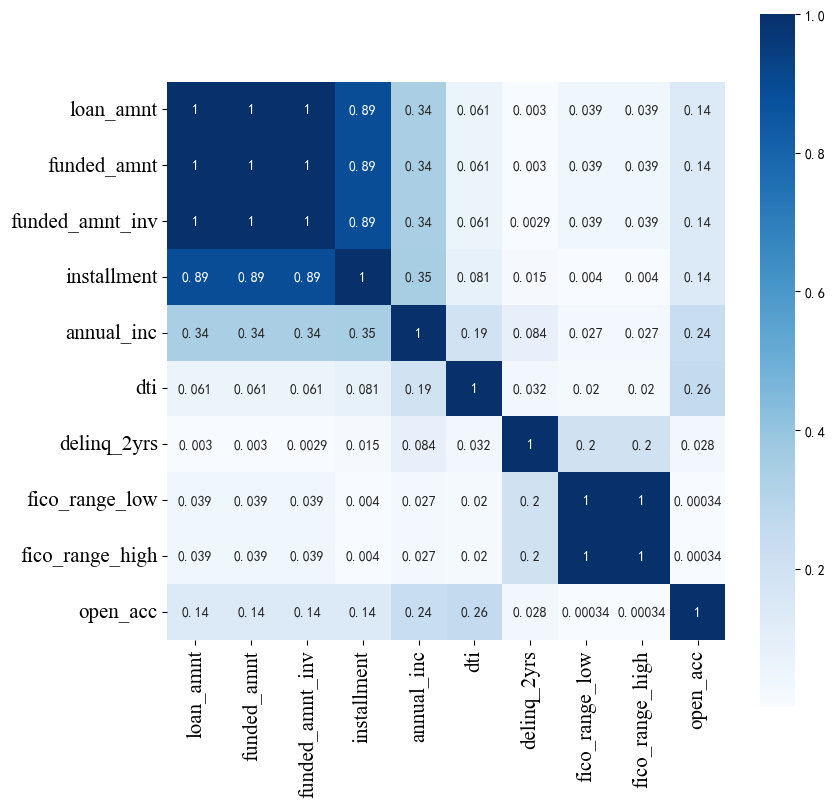

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots(figsize = (9, 9))
sns.heatmap(corr_matrix.iloc[:10,:10],annot = True,vmax = 1,square = True,cmap = "Blues")
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.show()

In [89]:
corr_matrix_1 = categorical_bin.corr(method = 'spearman').abs()

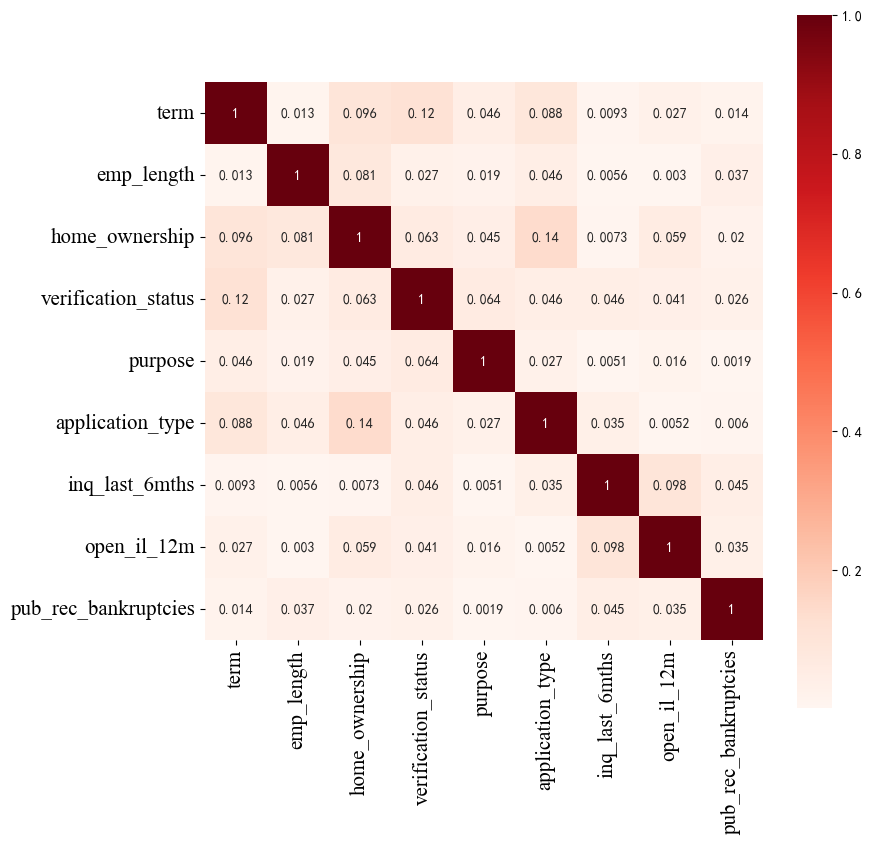

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots(figsize = (9, 9))
sns.heatmap(corr_matrix_1.iloc[:,:],annot = True,vmax = 1,square = True,cmap = "Reds")
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.show()

# IV预测能力分析

In [91]:
IV['特征变量新'] = [x[:-4] for x in IV['特征变量']]

In [92]:
IV_xin = IV[IV['特征变量新'].isin(data_X_bin_IV.columns)]

In [93]:
IV_xin

特征变量      IV                       特征变量新
58                        term_BIN  0.1438                        term
8              fico_range_high_BIN  0.1106             fico_range_high
3                  installment_BIN  0.0809                 installment
54             tot_hi_cred_lim_BIN  0.0718             tot_hi_cred_lim
38                    mort_acc_BIN  0.0672                    mort_acc
32              bc_open_to_buy_BIN  0.0604              bc_open_to_buy
60              home_ownership_BIN  0.0493              home_ownership
61         verification_status_BIN  0.0451         verification_status
23                 open_rv_24m_BIN  0.0317                 open_rv_24m
33                     bc_util_BIN  0.0316                     bc_util
43             num_actv_rev_tl_BIN  0.0306             num_actv_rev_tl
35        mo_sin_old_rev_tl_op_BIN  0.0300        mo_sin_old_rev_tl_op
59                  emp_length_BIN  0.0294                  emp_length
46                   num_il_tl_BIN  0.0289                   num_il_tl
34          mo_sin_old_il_acct_BIN  0.0256          mo_sin_old_il_acct
4                   annual_inc_BIN  0.0248                  annual_inc
5                          dti_BIN  0.0224                         dti
64              inq_last_6mths_BIN  0.0224              inq_last_6mths
40       mths_since_recent_inq_BIN  0.0209       mths_since_recent_inq
36       mo_sin_rcnt_rev_tl_op_BIN  0.0164       mo_sin_rcnt_rev_tl_op
29                inq_last_12m_BIN  0.0148                inq_last_12m
62                     purpose_BIN  0.0142                     purpose
24                  max_bal_bc_BIN  0.0127                  max_bal_bc
19          mths_since_rcnt_il_BIN  0.0105          mths_since_rcnt_il
57  total_il_high_credit_limit_BIN  0.0101  total_il_high_credit_limit
16                 open_acc_6m_BIN  0.0100                 open_acc_6m
28                 total_cu_tl_BIN  0.0096                 total_cu_tl
37              mo_sin_rcnt_tl_BIN  0.0092              mo_sin_rcnt_tl
52              pct_tl_nvr_dlq_BIN  0.0068              pct_tl_nvr_dlq
21                     il_util_BIN  0.0061                     il_util
27                      inq_fi_BIN  0.0054                      inq_fi
18                 open_il_24m_BIN  0.0032                 open_il_24m
14                tot_coll_amt_BIN  0.0031                tot_coll_amt
63            application_type_BIN  0.0028            application_type
6                  delinq_2yrs_BIN  0.0024                 delinq_2yrs
10                     pub_rec_BIN  0.0016                     pub_rec
66        pub_rec_bankruptcies_BIN  0.0009        pub_rec_bankruptcies
65                 open_il_12m_BIN  0.0004                 open_il_12m

In [94]:
IV_xin.shape

(38, 3)

In [95]:
#############表格中用黑色标记表示删除IV值不符合要求的特征
data_X_bin_IV = data_X_bin_IV[list(IV_xin['特征变量新'][IV_xin['IV'] > 0.02])]

In [96]:
IV_xin['特征变量新'][IV_xin['IV'] <= 0.02]

36         mo_sin_rcnt_rev_tl_op
29                  inq_last_12m
62                       purpose
24                    max_bal_bc
19            mths_since_rcnt_il
57    total_il_high_credit_limit
16                   open_acc_6m
28                   total_cu_tl
37                mo_sin_rcnt_tl
52                pct_tl_nvr_dlq
21                       il_util
27                        inq_fi
18                   open_il_24m
14                  tot_coll_amt
63              application_type
6                    delinq_2yrs
10                       pub_rec
66          pub_rec_bankruptcies
65                   open_il_12m
Name: 特征变量新, dtype: object

In [97]:
data_X_bin_IV.shape

(260149, 19)

In [98]:
data_X_bin_IV

term  fico_range_high  installment  tot_hi_cred_lim  mort_acc  \
1          2              1.0          4.0              3.0       4.0   
6          1              3.0          4.0              3.0       4.0   
8          1              2.0          1.0              2.0       1.0   
9          1              3.0          2.0              3.0       2.0   
10         1              4.0          3.0              5.0       3.0   
...      ...              ...          ...              ...       ...   
495227     2              2.0          4.0              3.0       3.0   
495230     1              2.0          2.0              1.0       1.0   
495233     1              2.0          4.0              2.0       4.0   
495234     1              1.0          2.0              3.0       2.0   
495237     1              2.0          4.0              4.0       4.0   

        bc_open_to_buy  home_ownership  verification_status  open_rv_24m  \
1                  3.0               2                    2          4.0   
6                  3.0               2                    3          1.0   
8                  1.0               3                    1          1.0   
9                  3.0               1                    2          3.0   
10                 6.0               1                    2          3.0   
...                ...             ...                  ...          ...   
495227             1.0               1                    1          3.0   
495230             1.0               2                    2          4.0   
495233             1.0               2                    1          1.0   
495234             1.0               1                    2          4.0   
495237             4.0               1                    2          4.0   

        bc_util  num_actv_rev_tl  mo_sin_old_rev_tl_op  emp_length  num_il_tl  \
1           2.0              3.0                   3.0         4.0        3.0   
6           4.0              2.0                   5.0         3.0        5.0   
8           5.0              3.0                   5.0         4.0        4.0   
9           1.0              1.0                   5.0         4.0        5.0   
10          6.0              3.0                   5.0         2.0        5.0   
...         ...              ...                   ...         ...        ...   
495227      3.0              5.0                   5.0         4.0        3.0   
495230      3.0              2.0                   1.0         6.0        3.0   
495233      5.0              3.0                   5.0         4.0        3.0   
495234      5.0              2.0                   5.0         3.0        3.0   
495237      3.0              2.0                   5.0         4.0        3.0   

        mo_sin_old_il_acct  annual_inc  dti  inq_last_6mths  \
1                      3.0         3.0  2.0               2   
6                      5.0         3.0  3.0               2   
8                      5.0         5.0  4.0               2   
9                      4.0         3.0  4.0               2   
10                     5.0         5.0  3.0               2   
...                    ...         ...  ...             ...   
495227                 5.0         3.0  2.0               3   
495230                 2.0         1.0  3.0               3   
495233                 3.0         2.0  3.0               2   
495234                 4.0         2.0  2.0               2   
495237                 1.0         3.0  3.0               4   

        mths_since_recent_inq  
1                         1.0  
6                         6.0  
8                         6.0  
9                         3.0  
10                        5.0  
...                       ...  
495227                    3.0  
495230                    4.0  
495233                    6.0  
495234                    5.0  
495237                    4.0  

[260149 rows x 19 columns]

In [99]:
data_10=IV_xin

In [100]:
data_10.drop(data_10.index[19:], inplace=True)

In [101]:
data_11=data_10.drop(["特征变量"],axis=1)

In [102]:
data_11

IV                  特征变量新
58  0.1438                   term
8   0.1106        fico_range_high
3   0.0809            installment
54  0.0718        tot_hi_cred_lim
38  0.0672               mort_acc
32  0.0604         bc_open_to_buy
60  0.0493         home_ownership
61  0.0451    verification_status
23  0.0317            open_rv_24m
33  0.0316                bc_util
43  0.0306        num_actv_rev_tl
35  0.0300   mo_sin_old_rev_tl_op
59  0.0294             emp_length
46  0.0289              num_il_tl
34  0.0256     mo_sin_old_il_acct
4   0.0248             annual_inc
5   0.0224                    dti
64  0.0224         inq_last_6mths
40  0.0209  mths_since_recent_inq

In [103]:
bin_var=['term','fico_range_high','installment','tot_hi_cred_lim','mort_acc','bc_open_to_buy','home_ownership',
        'verification_status','open_rv_24m','bc_util','num_actv_rev_tl','mo_sin_old_rev_tl_op','emp_length',
        'num_il_tl','mo_sin_old_il_acct','annual_inc','dti','inq_last_6mths','mths_since_recent_inq']

In [104]:
data_X2=data_X[bin_var]

In [105]:
pd.concat([data_X2,data_y],axis = 1).to_excel('2018年分箱调整所需要的数据.xlsx',index = False)

In [106]:
data_X2 = pd.read_excel('2018年分箱调整所需要的数据.xlsx',header = 0)

In [107]:
data_X2

term  fico_range_high  installment  tot_hi_cred_lim  mort_acc  \
0        60 months              669       560.94           172433         3   
1        36 months              739       602.21           168738         4   
2        36 months              699       161.15            98637         0   
3        36 months              719       320.01           217992         1   
4        36 months              764       467.47           512289         2   
...            ...              ...          ...              ...       ...   
260144   60 months              689       571.22           238344         2   
260145   36 months              709       176.14            17294         0   
260146   36 months              694       660.00            42400         3   
260147   36 months              669       176.14           161585         1   
260148   36 months              694       797.53           296500         6   

        bc_open_to_buy home_ownership verification_status  open_rv_24m  \
0              16684.0            OWN     Source Verified            5   
1              15288.0            OWN            Verified            0   
2               2157.0           RENT        Not Verified            0   
3              14181.0       MORTGAGE     Source Verified            3   
4                  NaN       MORTGAGE     Source Verified            3   
...                ...            ...                 ...          ...   
260144          3540.0       MORTGAGE        Not Verified            3   
260145          1822.0            OWN     Source Verified            6   
260146          1593.0            OWN        Not Verified            1   
260147           114.0       MORTGAGE     Source Verified            5   
260148         26321.0       MORTGAGE     Source Verified            6   

        bc_util  num_actv_rev_tl  mo_sin_old_rev_tl_op emp_length  num_il_tl  \
0          38.4                7                   112  10+ years          3   
1          69.7                4                   206    5 years         20   
2          75.2                6                   262  10+ years         10   
3          22.1                3                   304  10+ years         14   
4           NaN                6                   174    6 years         23   
...         ...              ...                   ...        ...        ...   
260144     51.0               16                   233  10+ years          4   
260145     43.1                4                    33        NaN          2   
260146     78.8                6                   177  10+ years          4   
260147     96.2                5                   178    3 years          3   
260148     44.1                5                   397  10+ years          3   

        mo_sin_old_il_acct  annual_inc    dti  inq_last_6mths  \
0                     67.0     85000.0  15.76             0.0   
1                    211.0     77000.0  22.21             0.0   
2                    162.0    120000.0  24.88             0.0   
3                    119.0     65000.0  27.20             0.0   
4                    140.0    148000.0  23.62             0.0   
...                    ...         ...    ...             ...   
260144               191.0     60000.0   9.72             1.0   
260145                41.0      9200.0  23.50             1.0   
260146                71.0     45000.0  22.13             0.0   
260147               120.0     46400.0  16.85             0.0   
260148                12.0     75000.0  20.95             2.0   

        mths_since_recent_inq  loan_status  
0                         0.0            0  
1                         NaN            0  
2                         NaN            0  
3                         3.0            0  
4                        18.0            0  
...                       ...          ...  
260144                    3.0            0  
260145                    6.0            0  
260146                    NaN

In [108]:
## 将空值填充为 '999999999'
data_X2['bc_open_to_buy'] = data_X2['bc_open_to_buy'].fillna('999999999.0')
## 将空值填充为 '999999999'
data_X2['bc_util'] = data_X2['bc_util'].fillna('999999999.0')
## 将空值填充为 '999999999'
data_X2['mo_sin_old_il_acct'] = data_X2['mo_sin_old_il_acct'].fillna('999999999.0')
## 将空值填充为 '999999999'
data_X2['dti'] = data_X2['dti'].fillna('999999999.0')
## 将空值填充为 '999999999'
data_X2['mths_since_recent_inq'] = data_X2['mths_since_recent_inq'].fillna('999999999.0')

In [109]:
data_X2.to_excel('2018调整后的数据(程序内部使用).xlsx',index = False)

In [110]:
data_X2 = pd.read_excel('2018调整后的数据(程序内部使用).xlsx',header = 0)

In [111]:
data_X2 

term  fico_range_high  installment  tot_hi_cred_lim  mort_acc  \
0        60 months              669       560.94           172433         3   
1        36 months              739       602.21           168738         4   
2        36 months              699       161.15            98637         0   
3        36 months              719       320.01           217992         1   
4        36 months              764       467.47           512289         2   
...            ...              ...          ...              ...       ...   
260144   60 months              689       571.22           238344         2   
260145   36 months              709       176.14            17294         0   
260146   36 months              694       660.00            42400         3   
260147   36 months              669       176.14           161585         1   
260148   36 months              694       797.53           296500         6   

        bc_open_to_buy home_ownership verification_status  open_rv_24m  \
0              16684.0            OWN     Source Verified            5   
1              15288.0            OWN            Verified            0   
2               2157.0           RENT        Not Verified            0   
3              14181.0       MORTGAGE     Source Verified            3   
4          999999999.0       MORTGAGE     Source Verified            3   
...                ...            ...                 ...          ...   
260144          3540.0       MORTGAGE        Not Verified            3   
260145          1822.0            OWN     Source Verified            6   
260146          1593.0            OWN        Not Verified            1   
260147           114.0       MORTGAGE     Source Verified            5   
260148         26321.0       MORTGAGE     Source Verified            6   

            bc_util  num_actv_rev_tl  mo_sin_old_rev_tl_op emp_length  \
0              38.4                7                   112  10+ years   
1              69.7                4                   206    5 years   
2              75.2                6                   262  10+ years   
3              22.1                3                   304  10+ years   
4       999999999.0                6                   174    6 years   
...             ...              ...                   ...        ...   
260144         51.0               16                   233  10+ years   
260145         43.1                4                    33        NaN   
260146         78.8                6                   177  10+ years   
260147         96.2                5                   178    3 years   
260148         44.1                5                   397  10+ years   

        num_il_tl  mo_sin_old_il_acct  annual_inc    dti  inq_last_6mths  \
0               3                67.0     85000.0  15.76               0   
1              20               211.0     77000.0  22.21               0   
2              10               162.0    120000.0  24.88               0   
3              14               119.0     65000.0  27.20               0   
4              23               140.0    148000.0  23.62               0   
...           ...                 ...         ...    ...             ...   
260144          4               191.0     60000.0   9.72               1   
260145          2                41.0      9200.0  23.50               1   
260146          4                71.0     45000.0  22.13               0   
260147          3               120.0     46400.0  16.85               0   
260148          3                12.0     75000.0  20.95               2   

        mths_since_recent_inq  loan_status  
0                         0.0            0  
1                 999999999.0            0  
2                 999999999.0            0  
3                         3.0            0  
4                        18.0            0  
...                       ...          ...  
260144                    3.0            0  
260145                    

In [112]:
data_X2['bc_open_to_buy'] = data_X2['bc_open_to_buy']+1

In [113]:
data_X2['bc_util'] = data_X2['bc_util']+1

In [114]:
data_X2['mo_sin_old_il_acct'] = data_X2['mo_sin_old_il_acct']+1

In [115]:
data_X2['dti'] = data_X2['dti']+1

In [116]:
data_X2['mths_since_recent_inq'] = data_X2['mths_since_recent_inq']+1

In [117]:
## 将 '1000000000'还原为0
data_X2['bc_open_to_buy'] = data_X2['bc_open_to_buy'].replace([1000000000],[0])
## 将 '1000000000'还原为0
data_X2['bc_util'] = data_X2['bc_util'].replace([1000000000],[0])
## 将 '1000000000'还原为0
data_X2['mo_sin_old_il_acct'] = data_X2['mo_sin_old_il_acct'].replace([1000000000],[0])
## 将 '1000000000'还原为0
data_X2['dti'] = data_X2['dti'].replace([1000000000],[0])

In [118]:
## 根据Bivar图进行调整
data_X2['bc_open_to_buy'] = data_X2['bc_open_to_buy'].replace([0],[12000])

In [119]:
## 根据Bivar图进行调整
data_X2['bc_util'] = data_X2['bc_util'].replace([0],[40])

In [120]:
data_X2

term  fico_range_high  installment  tot_hi_cred_lim  mort_acc  \
0        60 months              669       560.94           172433         3   
1        36 months              739       602.21           168738         4   
2        36 months              699       161.15            98637         0   
3        36 months              719       320.01           217992         1   
4        36 months              764       467.47           512289         2   
...            ...              ...          ...              ...       ...   
260144   60 months              689       571.22           238344         2   
260145   36 months              709       176.14            17294         0   
260146   36 months              694       660.00            42400         3   
260147   36 months              669       176.14           161585         1   
260148   36 months              694       797.53           296500         6   

        bc_open_to_buy home_ownership verification_status  open_rv_24m  \
0              16685.0            OWN     Source Verified            5   
1              15289.0            OWN            Verified            0   
2               2158.0           RENT        Not Verified            0   
3              14182.0       MORTGAGE     Source Verified            3   
4              12000.0       MORTGAGE     Source Verified            3   
...                ...            ...                 ...          ...   
260144          3541.0       MORTGAGE        Not Verified            3   
260145          1823.0            OWN     Source Verified            6   
260146          1594.0            OWN        Not Verified            1   
260147           115.0       MORTGAGE     Source Verified            5   
260148         26322.0       MORTGAGE     Source Verified            6   

        bc_util  num_actv_rev_tl  mo_sin_old_rev_tl_op emp_length  num_il_tl  \
0          39.4                7                   112  10+ years          3   
1          70.7                4                   206    5 years         20   
2          76.2                6                   262  10+ years         10   
3          23.1                3                   304  10+ years         14   
4          40.0                6                   174    6 years         23   
...         ...              ...                   ...        ...        ...   
260144     52.0               16                   233  10+ years          4   
260145     44.1                4                    33        NaN          2   
260146     79.8                6                   177  10+ years          4   
260147     97.2                5                   178    3 years          3   
260148     45.1                5                   397  10+ years          3   

        mo_sin_old_il_acct  annual_inc    dti  inq_last_6mths  \
0                     68.0     85000.0  16.76               0   
1                    212.0     77000.0  23.21               0   
2                    163.0    120000.0  25.88               0   
3                    120.0     65000.0  28.20               0   
4                    141.0    148000.0  24.62               0   
...                    ...         ...    ...             ...   
260144               192.0     60000.0  10.72               1   
260145                42.0      9200.0  24.50               1   
260146                72.0     45000.0  23.13               0   
260147               121.0     46400.0  17.85               0   
260148                13.0     75000.0  21.95               2   

        mths_since_recent_inq  loan_status  
0                1.000000e+00            0  
1                1.000000e+09            0  
2                1.000000e+09            0  
3                4.000000e+00            0  
4                1.900000e+01            0  
...                       ...          ...  
260144           4.000000e+00            0  
260145           7.000000e+00            0  
260146           1.000000e+09

In [121]:
import toad
from toad.plot import  bin_plot,badrate_plot

In [122]:
categorical_var_bin.get('term')

loan_status   total  bin    var_name
0            192364    1   36 months
1             67785    2   60 months

{'term': [[' 36 months'], [' 60 months']]}


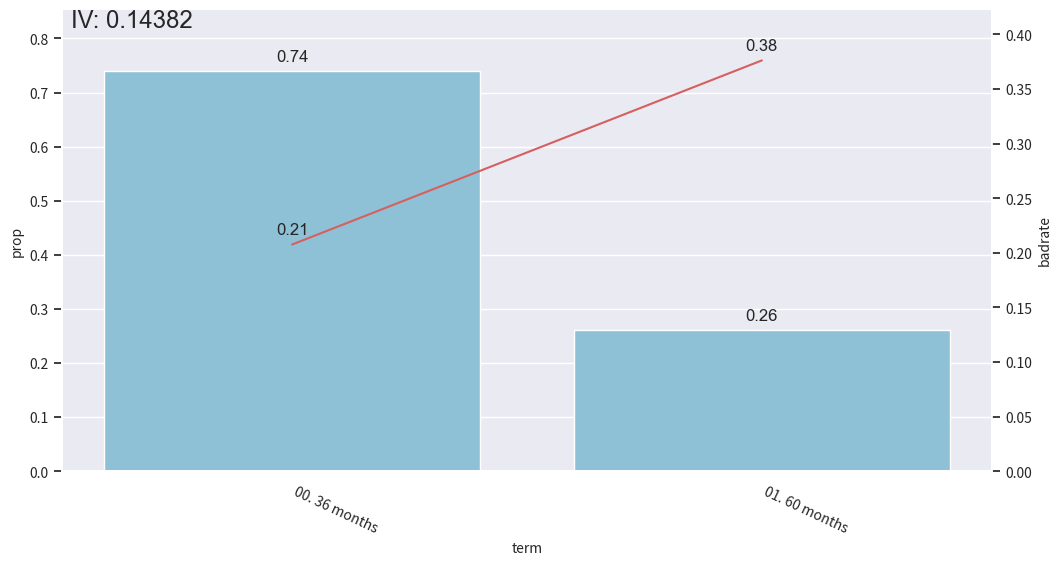

In [123]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['term','loan_status']],
        y='loan_status', method='chi',n_bins=2)  
bin_plot(c1.transform(data_X2[['term','loan_status']],
           labels=True), x='term', target='loan_status')
print(c1.export())

In [124]:
continuous_var_bin.get('fico_range_high')

bin_low  bin_up  total  bin
bin                             
1       -inf   684.0  81466    1
2      684.0   709.0  71624    2
3      709.0   744.0  64380    3
4      744.0   774.0  25540    4
5      774.0     inf  17139    5

{'fico_range_high': [689, 709, 729, 779]}


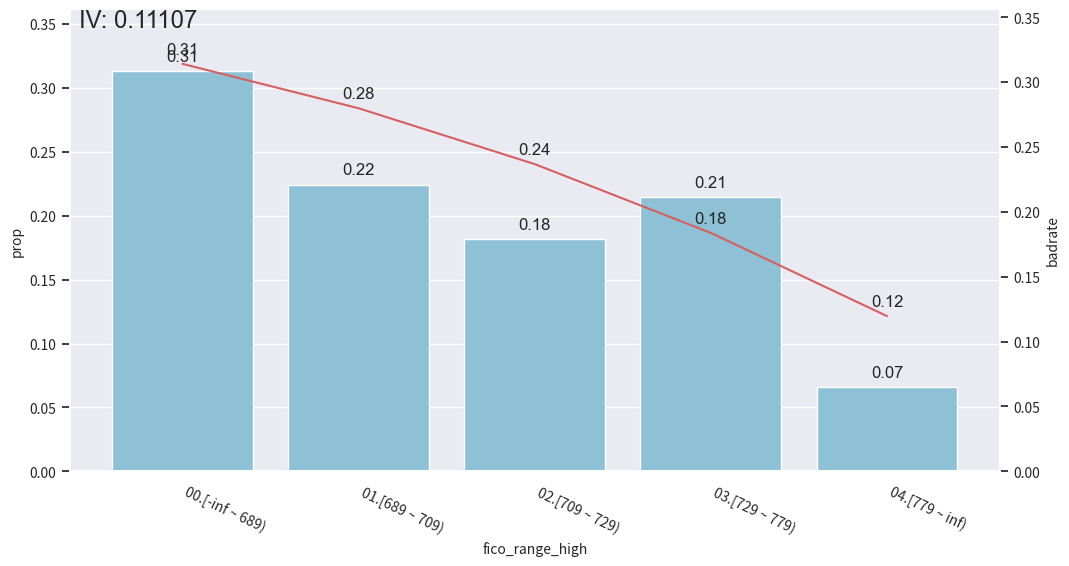

In [125]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['fico_range_high','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['fico_range_high','loan_status']],
           labels=True), x='fico_range_high', target='loan_status')
print(c1.export())

<Axes: xlabel='fico_range_high', ylabel='prop'>

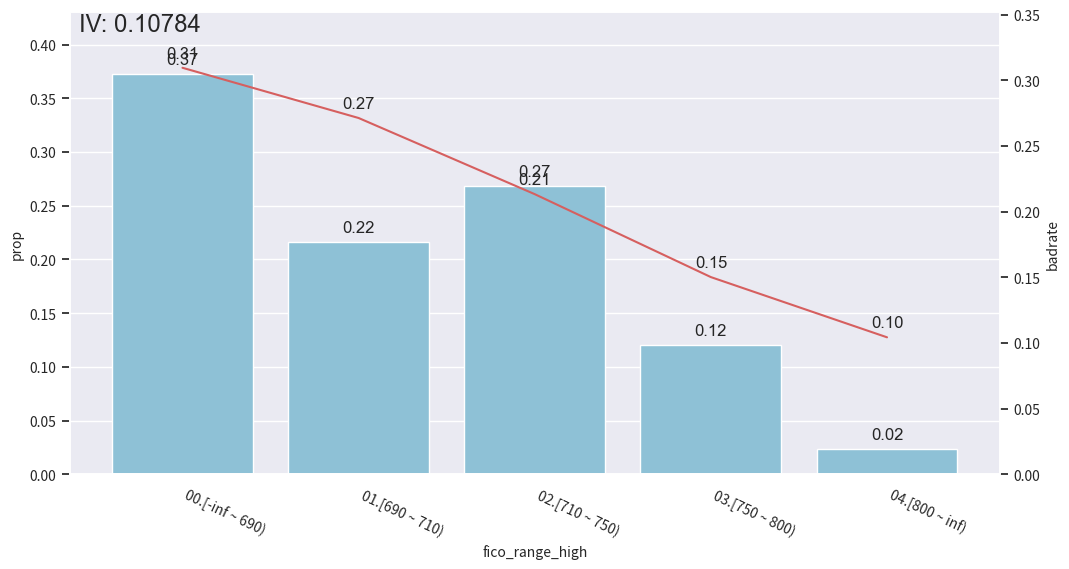

In [126]:
#设置分组
rule = {'fico_range_high':[690,710,750,800]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['fico_range_high','loan_status']], labels=True), x='fico_range_high', target='loan_status')

In [127]:
continuous_var_bin.get('installment')

bin_low     bin_up  total  bin
bin                                  
1         -inf   162.0652  30049    1
2     162.0652   328.8216  75653    2
3     328.8216   505.3872  61211    3
4     505.3872  1064.5116  78918    4
5    1064.5116        inf  14318    5

{'installment': [166.05, 323.43, 473.31, 1204.42]}


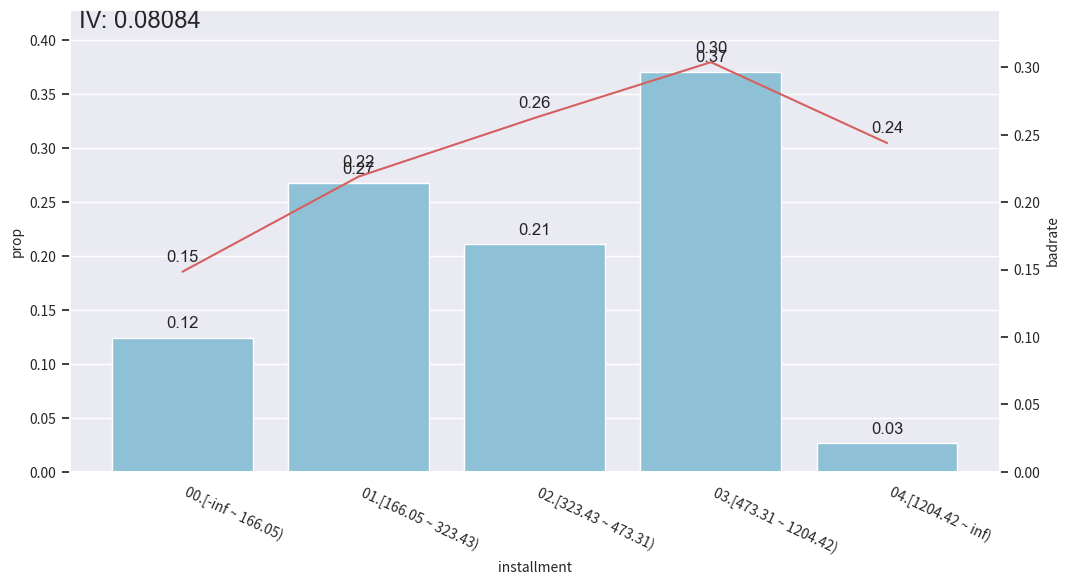

In [128]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['installment','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['installment','loan_status']],
           labels=True), x='installment', target='loan_status')
print(c1.export())

<Axes: xlabel='installment', ylabel='prop'>

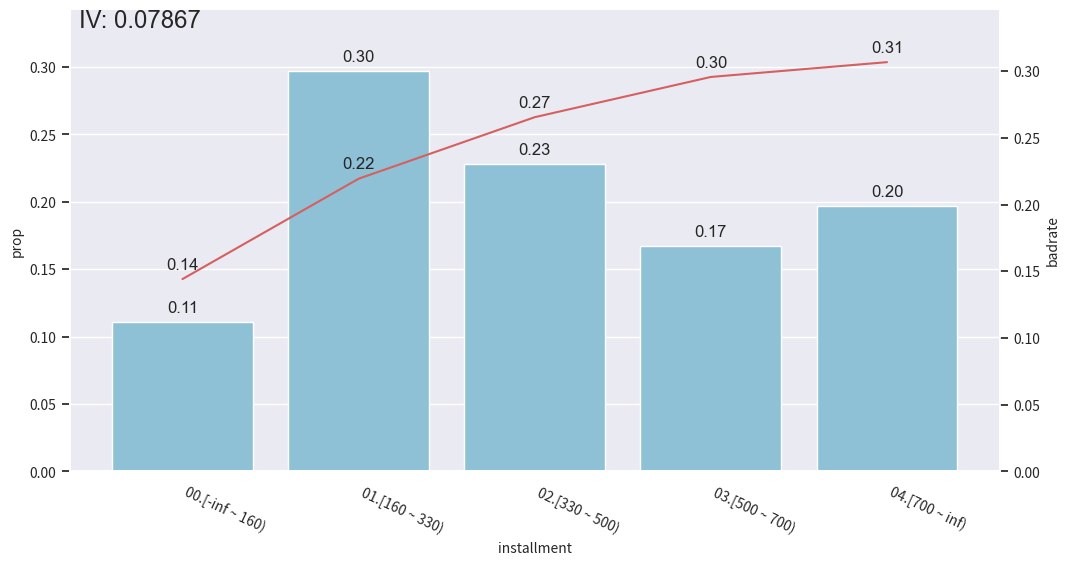

In [129]:
#设置分组
rule = {'installment':[160,330,500,700]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['installment','loan_status']], labels=True), x='installment', target='loan_status')

In [130]:
continuous_var_bin.get('tot_hi_cred_lim')

bin_low     bin_up  total  bin
bin                                  
1         -inf   38459.88  42935    1
2     38459.88  121107.40  88321    2
3    121107.40  239913.21  52143    3
4    239913.21  487855.77  59165    4
5    487855.77        inf  17585    5

{'tot_hi_cred_lim': [22661, 69599, 122282, 227425]}


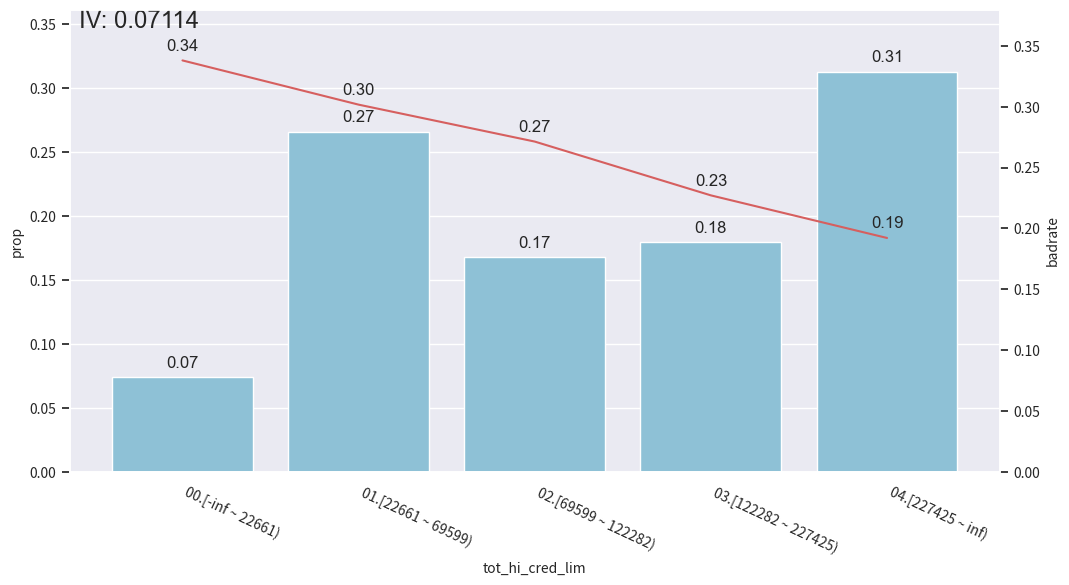

In [131]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['tot_hi_cred_lim','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['tot_hi_cred_lim','loan_status']],
           labels=True), x='tot_hi_cred_lim', target='loan_status')
print(c1.export())

<Axes: xlabel='tot_hi_cred_lim', ylabel='prop'>

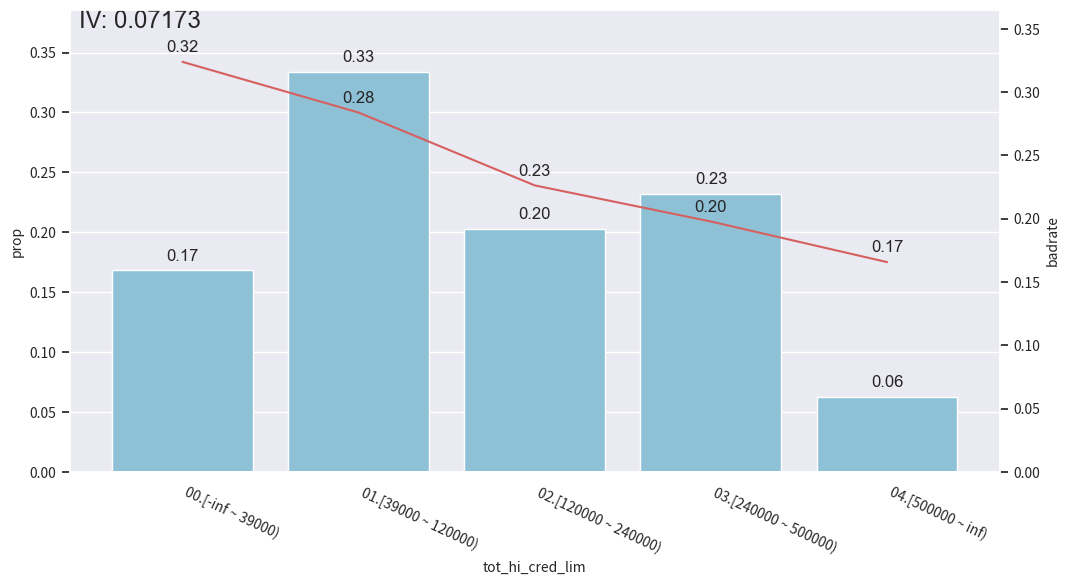

In [132]:
#设置分组
rule = {'tot_hi_cred_lim':[39000,120000,240000,500000]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['tot_hi_cred_lim','loan_status']], labels=True), x='tot_hi_cred_lim', target='loan_status')

In [133]:
continuous_var_bin.get('mort_acc')

bin_low  bin_up   total  bin
bin                              
1       -inf    0.24  116286    1
2       0.24    1.20   47631    2
3       1.20    2.16   38859    3
4       2.16     inf   57373    4

{'mort_acc': [1, 2, 3]}


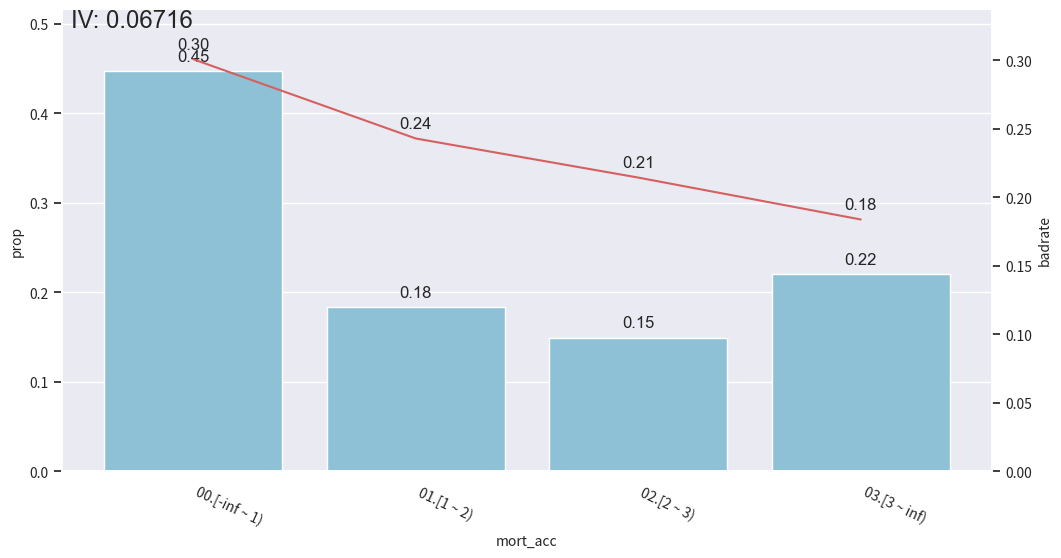

In [134]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['mort_acc','loan_status']],
        y='loan_status', method='chi',n_bins=4)  
bin_plot(c1.transform(data_X2[['mort_acc','loan_status']],
           labels=True), x='mort_acc', target='loan_status')
print(c1.export())

In [135]:
continuous_var_bin.get('bc_open_to_buy')

bin_low    bin_up  total  bin
bin                                
1        -inf   5626.50  98879  1.0
2     5626.50  11976.30  54399  2.0
3    11976.30  19913.55  38315  3.0
4    19913.55  40021.25  41408  4.0
5    40021.25       inf  23393  5.0
6         NaN       NaN   3755  6.0

{'bc_open_to_buy': [5253.0, 7377.0, 11873.0, 20128.0, 41135.0]}


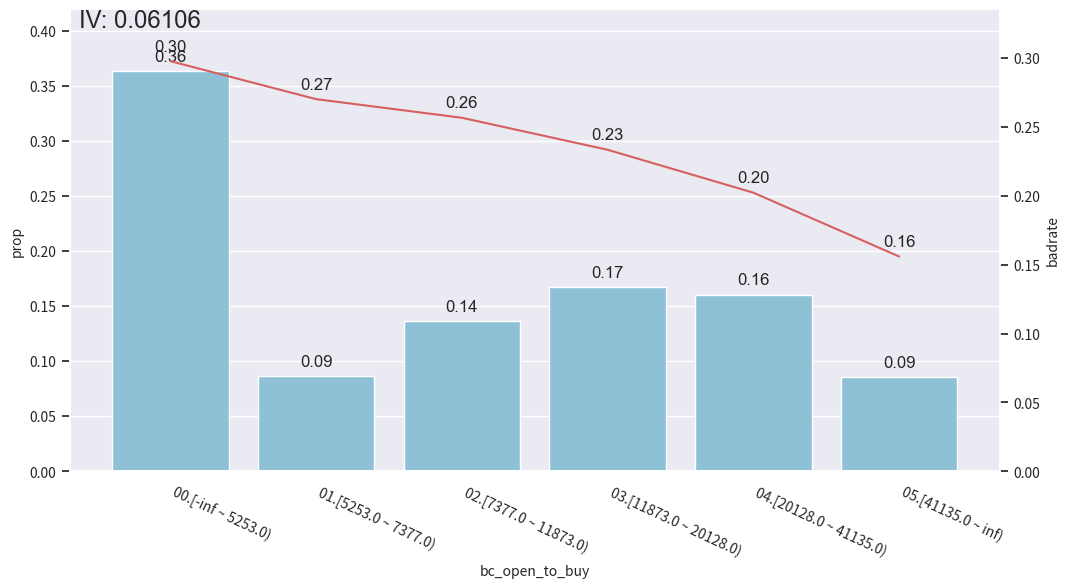

In [136]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['bc_open_to_buy','loan_status']],
        y='loan_status', method='chi',n_bins=6)  
bin_plot(c1.transform(data_X2[['bc_open_to_buy','loan_status']],
           labels=True), x='bc_open_to_buy', target='loan_status')
print(c1.export())

<Axes: xlabel='bc_open_to_buy', ylabel='prop'>

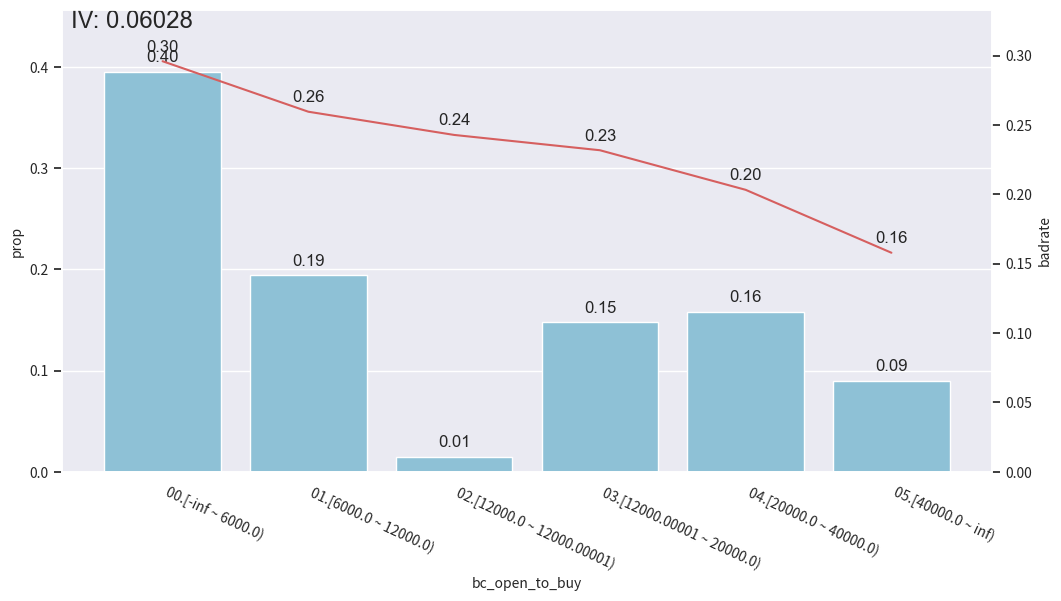

In [137]:
#设置分组
rule = {'bc_open_to_buy':[6000,12000,12000.00001,20000,40000]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['bc_open_to_buy','loan_status']], labels=True), x='bc_open_to_buy', target='loan_status')

In [138]:
categorical_var_bin.get('home_ownership')

loan_status   total  bin  var_name
0            126720    1  MORTGAGE
1             31624    2       OWN
2            101587    3      RENT
3               218    4       ANY

{'home_ownership': [['MORTGAGE'], ['OWN'], ['RENT', 'ANY']]}


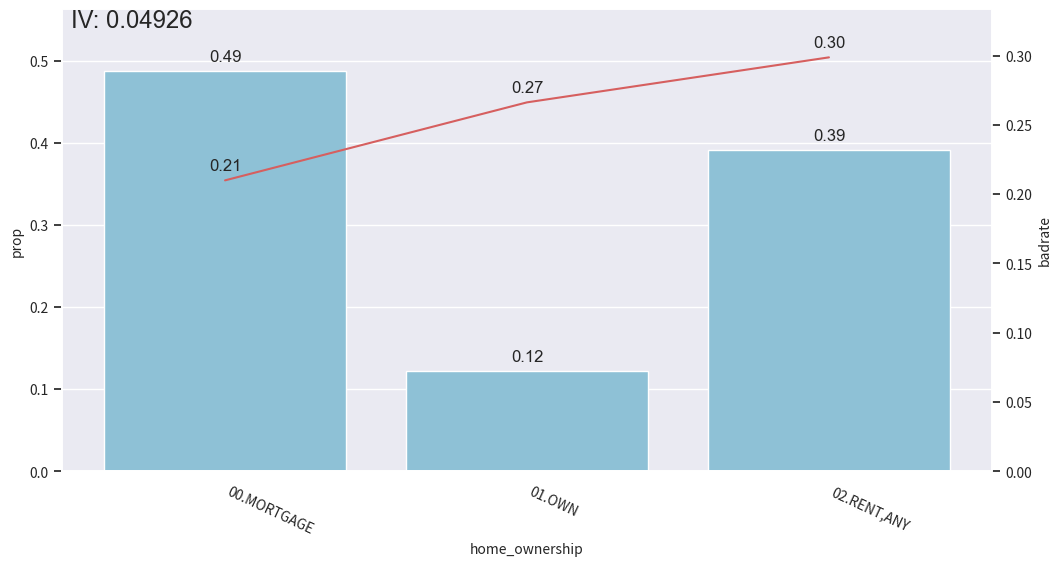

In [139]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['home_ownership','loan_status']],
        y='loan_status', method='chi',n_bins=3)  
bin_plot(c1.transform(data_X2[['home_ownership','loan_status']],
           labels=True), x='home_ownership', target='loan_status')
print(c1.export())

<Axes: xlabel='home_ownership', ylabel='prop'>

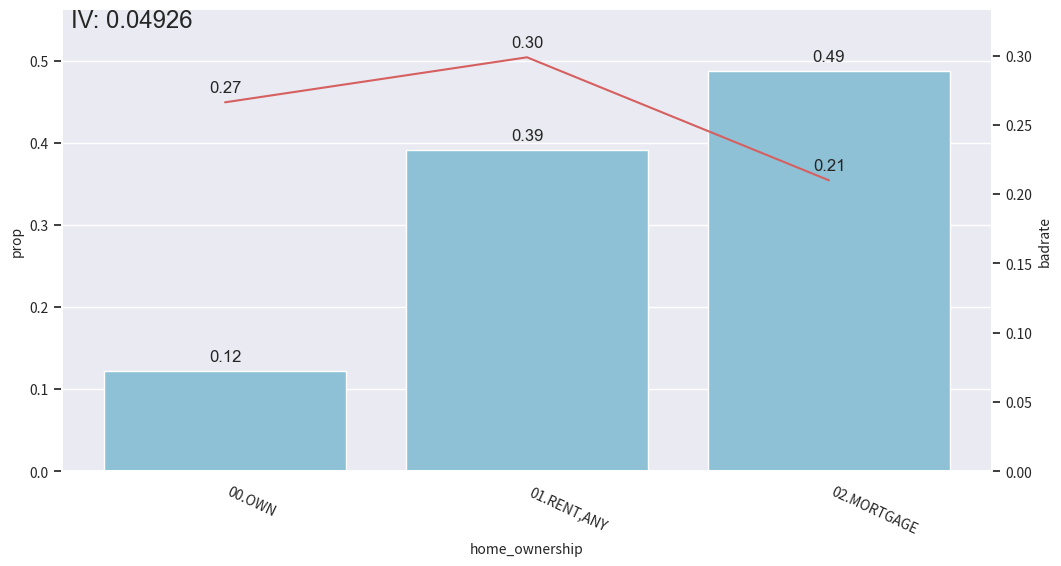

In [140]:
#设置分组
rule = {'home_ownership':[['OWN'], ['RENT','ANY'],['MORTGAGE']]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['home_ownership','loan_status']], labels=True), x='home_ownership', target='loan_status')

In [141]:
categorical_var_bin.get('verification_status')

loan_status   total  bin         var_name
0            102128    1     Not Verified
1            104206    2  Source Verified
2             53815    3         Verified

{'verification_status': [['Not Verified'], ['Source Verified'], ['Verified']]}


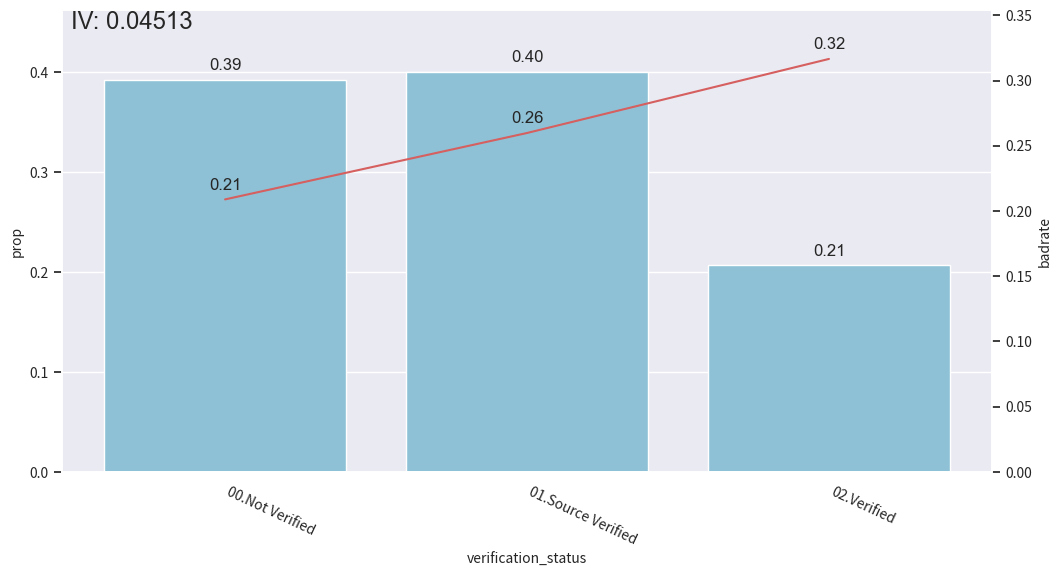

In [142]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['verification_status','loan_status']],
        y='loan_status', method='chi',n_bins=3)  
bin_plot(c1.transform(data_X2[['verification_status','loan_status']],
           labels=True), x='verification_status', target='loan_status')
print(c1.export())

In [143]:
continuous_var_bin.get('open_rv_24m')

bin_low  bin_up  total  bin
bin                             
1       -inf    1.08  97186    1
2       1.08    2.07  49477    2
3       2.07    3.06  37059    3
4       3.06    6.03  54193    4
5       6.03     inf  22234    5

{'open_rv_24m': [2, 3, 4, 7]}


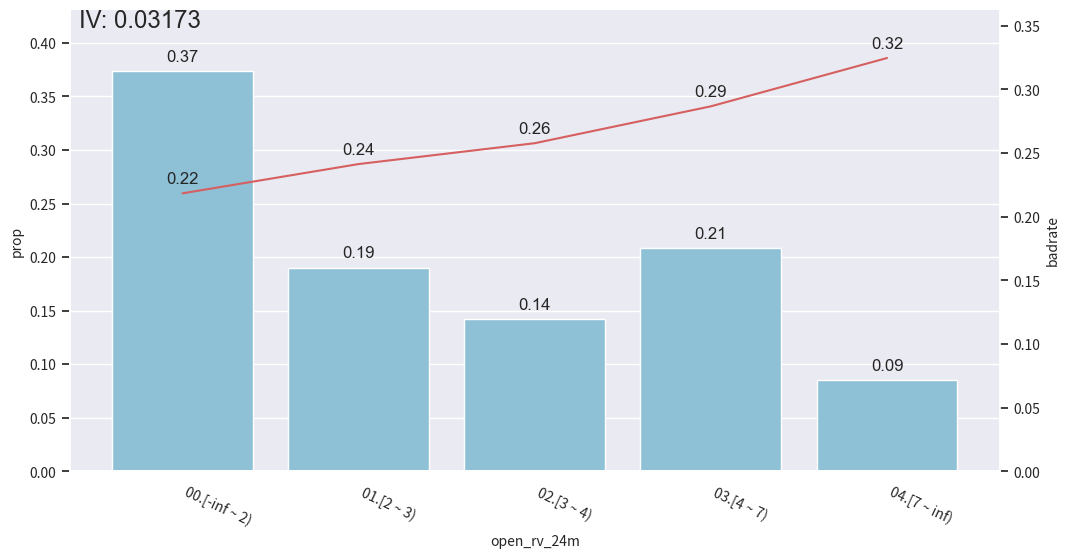

In [144]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['open_rv_24m','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['open_rv_24m','loan_status']],
           labels=True), x='open_rv_24m', target='loan_status')
print(c1.export())

In [145]:
continuous_var_bin.get('bc_util')

bin_low  bin_up  total  bin
bin                             
1       -inf  25.775  71487  1.0
2     25.775  38.865  37642  2.0
3     38.865  54.760  42813  3.0
4     54.760  71.590  39375  4.0
5     71.590     inf  64937  5.0
6        NaN     NaN   3895  6.0

{'bc_util': [1.7, 23.2, 33.0, 52.3, 73.0]}


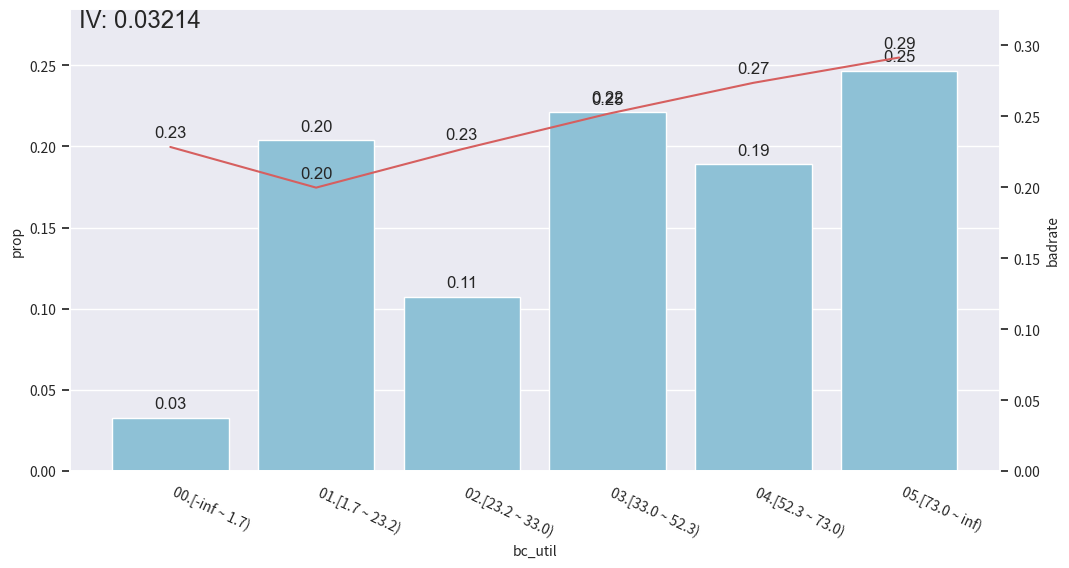

In [146]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['bc_util','loan_status']],
        y='loan_status', method='chi',n_bins=6)  
bin_plot(c1.transform(data_X2[['bc_util','loan_status']],
           labels=True), x='bc_util', target='loan_status')
print(c1.export())

<Axes: xlabel='bc_util', ylabel='prop'>

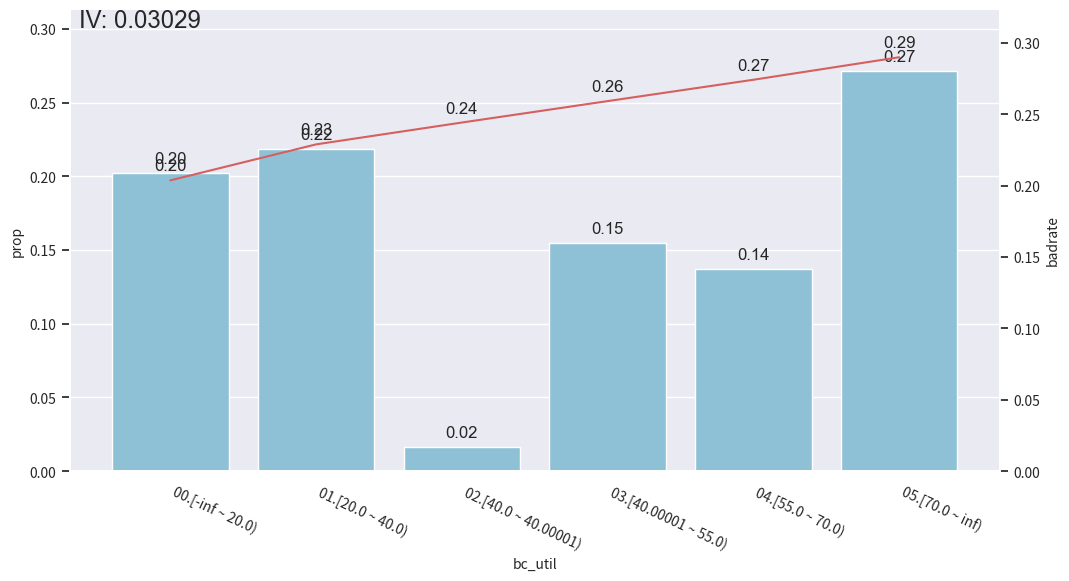

In [147]:
#设置分组
rule = {'bc_util':[20,40,40.00001,55,70]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['bc_util','loan_status']], labels=True), x='bc_util', target='loan_status')

In [148]:
continuous_var_bin.get('num_actv_rev_tl')

bin_low  bin_up  total  bin
bin                             
1       -inf    3.00  91907    1
2       3.00    5.04  72833    2
3       5.04    8.04  60147    3
4       8.04   10.08  17444    4
5      10.08     inf  17818    5

{'num_actv_rev_tl': [4, 5, 7, 9]}


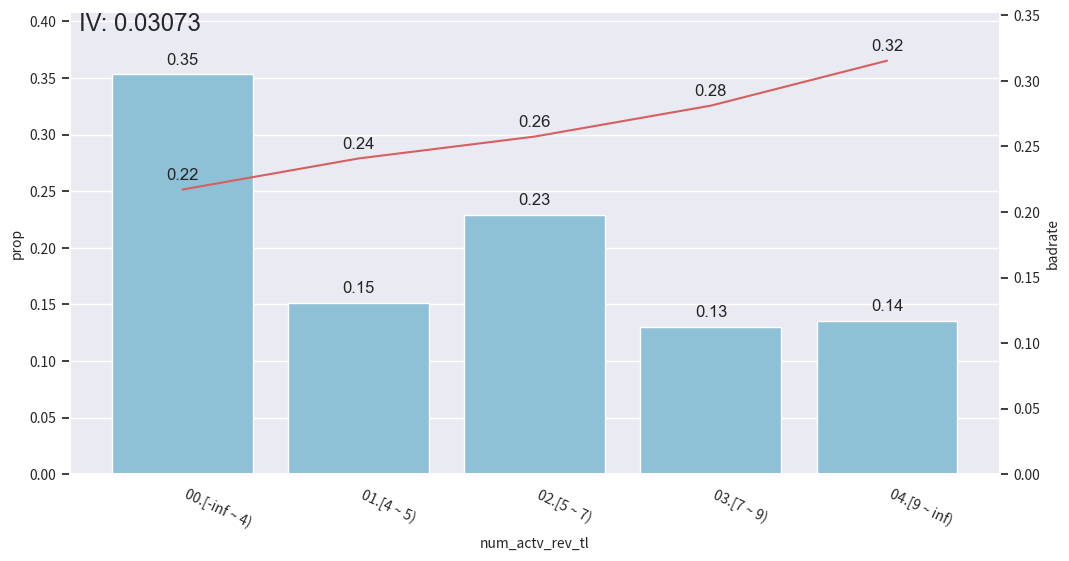

In [149]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['num_actv_rev_tl','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['num_actv_rev_tl','loan_status']],
           labels=True), x='num_actv_rev_tl', target='loan_status')
print(c1.export())

In [150]:
continuous_var_bin.get('mo_sin_old_rev_tl_op')

bin_low  bin_up   total  bin
bin                              
1       -inf   48.42   18191    1
2      48.42   83.73   32683    2
3      83.73  128.67   41418    3
4     128.67  151.14   35495    4
5     151.14     inf  132362    5

{'mo_sin_old_rev_tl_op': [49, 79, 153, 470]}


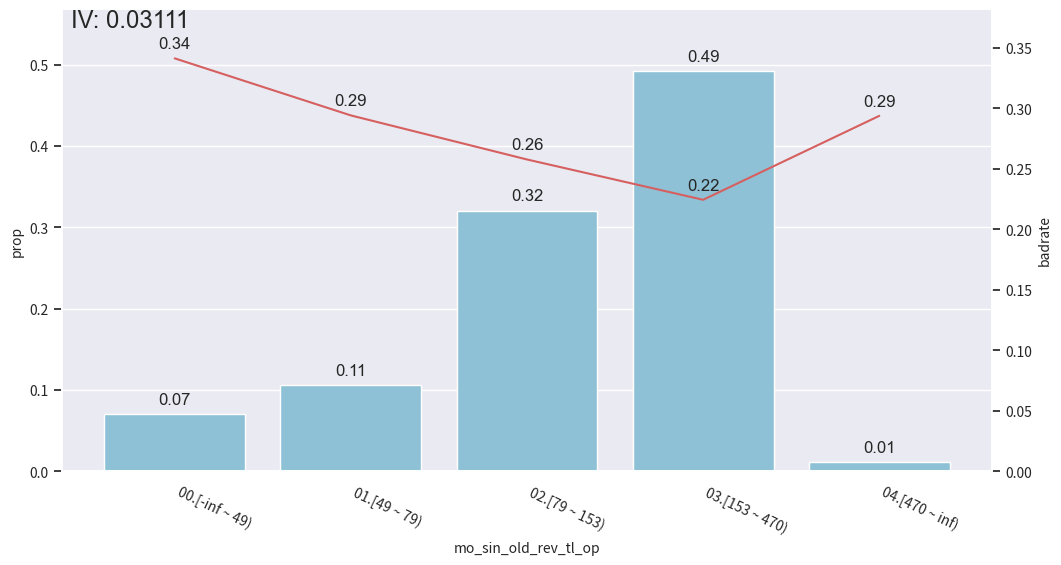

In [151]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['mo_sin_old_rev_tl_op','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['mo_sin_old_rev_tl_op','loan_status']],
           labels=True), x='mo_sin_old_rev_tl_op', target='loan_status')
print(c1.export())

<Axes: xlabel='mo_sin_old_rev_tl_op', ylabel='prop'>

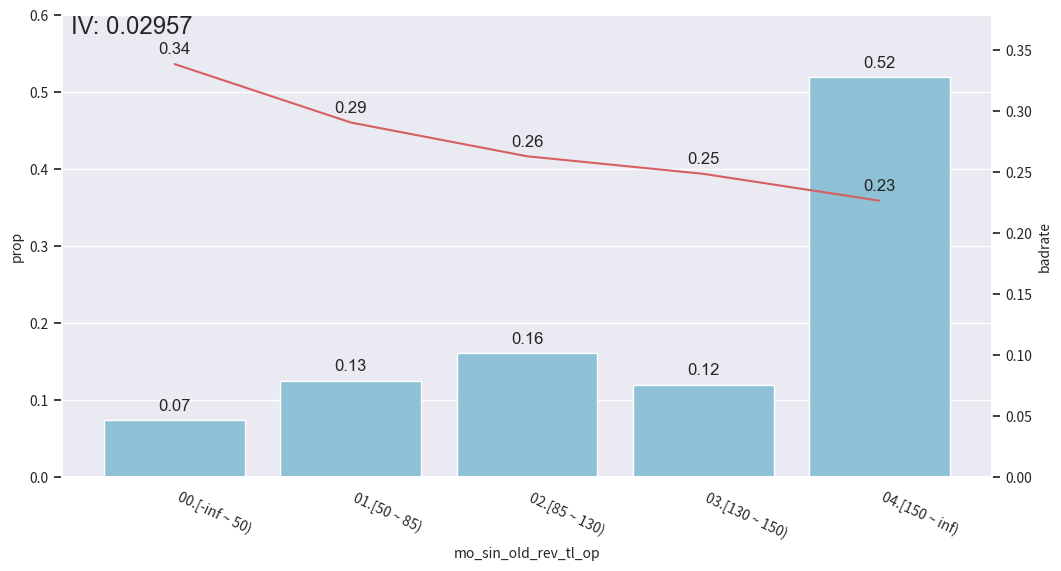

In [152]:
#设置分组
rule = {'mo_sin_old_rev_tl_op': [50,85,130,150]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['mo_sin_old_rev_tl_op','loan_status']], labels=True), x='mo_sin_old_rev_tl_op', target='loan_status')

In [153]:
categorical_var_bin.get('emp_length')

loan_status    total  bin   var_name
0            22398.0  1.0   < 1 year
1            11723.0  2.0    6 years
2             9566.0  2.0    7 years
3             8415.0  2.0    8 years
4            24168.0  3.0    2 years
5            16859.0  3.0    4 years
6            21845.0  3.0    3 years
7            16427.0  3.0    5 years
8            82768.0  4.0  10+ years
9             6588.0  4.0    9 years
10           17764.0  5.0     1 year
11           21628.0  6.0         NA

{'emp_length': [['10+ years'], ['9 years'], ['6 years', '7 years'], ['8 years'], ['2 years'], ['4 years'], ['3 years'], ['5 years'], ['1 year'], ['< 1 year'], ['nan']]}


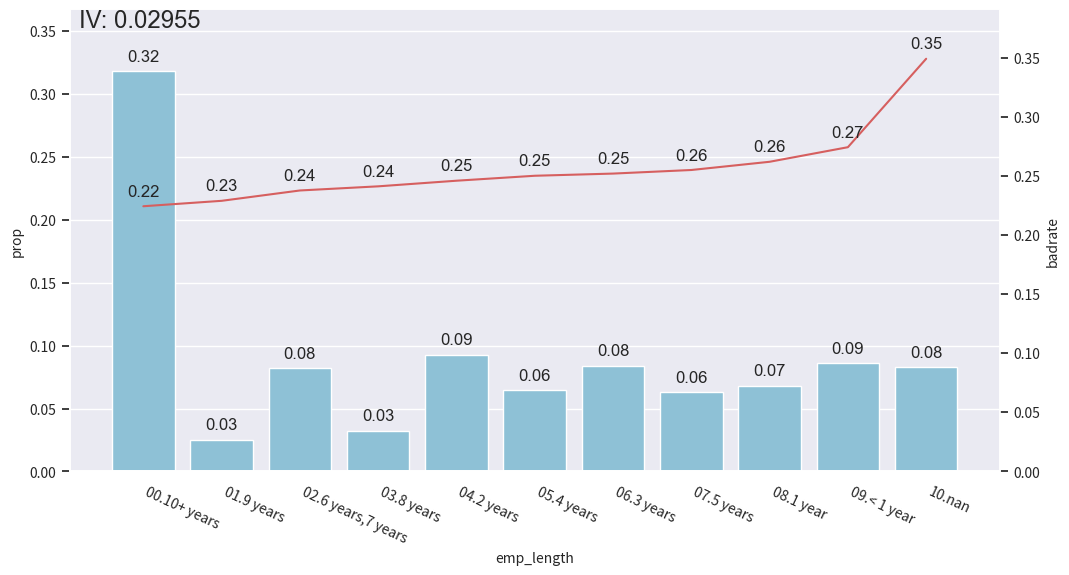

In [154]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['emp_length','loan_status']],
        y='loan_status', method='chi',n_bins=11)  
bin_plot(c1.transform(data_X2[['emp_length','loan_status']],
           labels=True), x='emp_length', target='loan_status')
print(c1.export())

<Axes: xlabel='emp_length', ylabel='prop'>

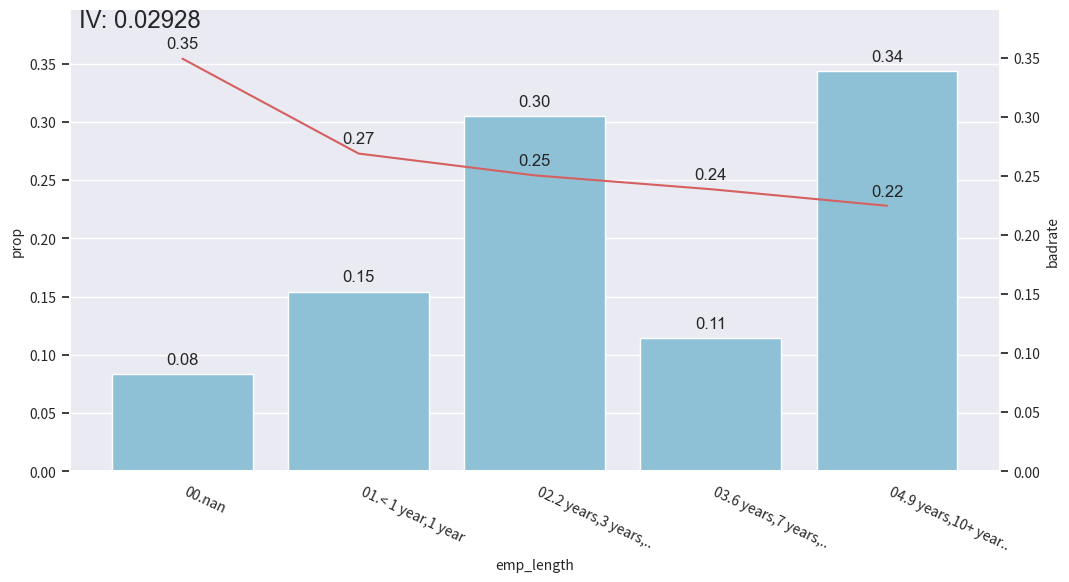

In [155]:
#设置分组
rule = {'emp_length':[['nan'],['< 1 year','1 year'], ['2 years','3 years','4 years','5 years'], ['6 years','7 years','8 years'], ['9 years','10+ years']]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['emp_length','loan_status']], labels=True), x='emp_length', target='loan_status')

<Axes: xlabel='emp_length', ylabel='prop'>

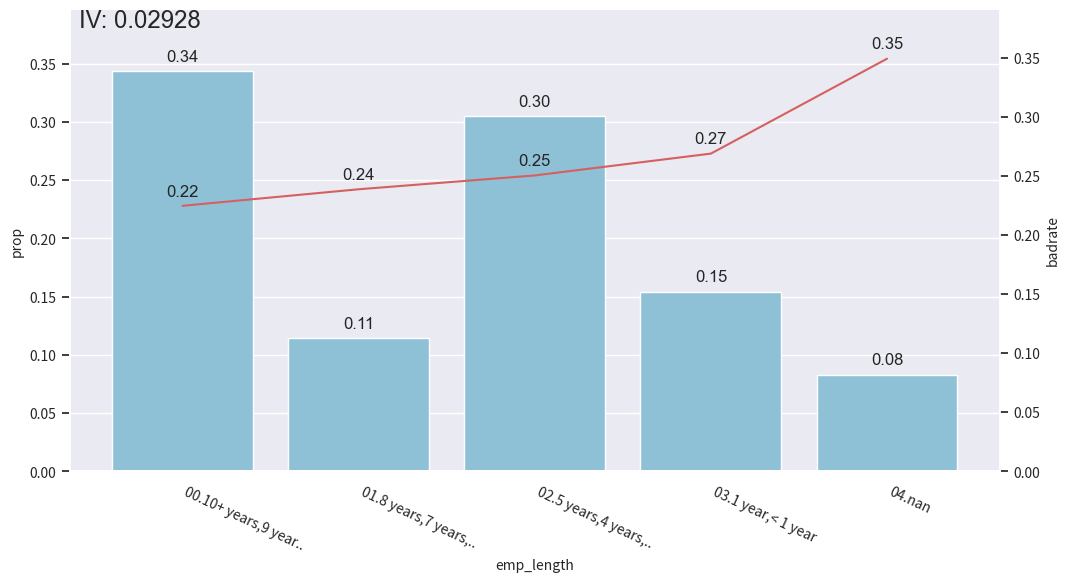

In [156]:
#设置分组
rule = {'emp_length':[['10+ years', '9 years'], ['8 years','7 years','6 years'], ['5 years', '4 years', '3 years', '2 years'], ['1 year', '< 1 year'], ['nan']]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['emp_length','loan_status']], labels=True), x='emp_length', target='loan_status')

In [157]:
continuous_var_bin.get('num_il_tl')

bin_low  bin_up  total  bin
bin                             
1       -inf    0.24   9105    1
2       0.24    1.20  16013    2
3       1.20    4.08  64560    3
4       4.08   10.08  97790    4
5      10.08     inf  72681    5

{'num_il_tl': [2, 4, 7, 11]}


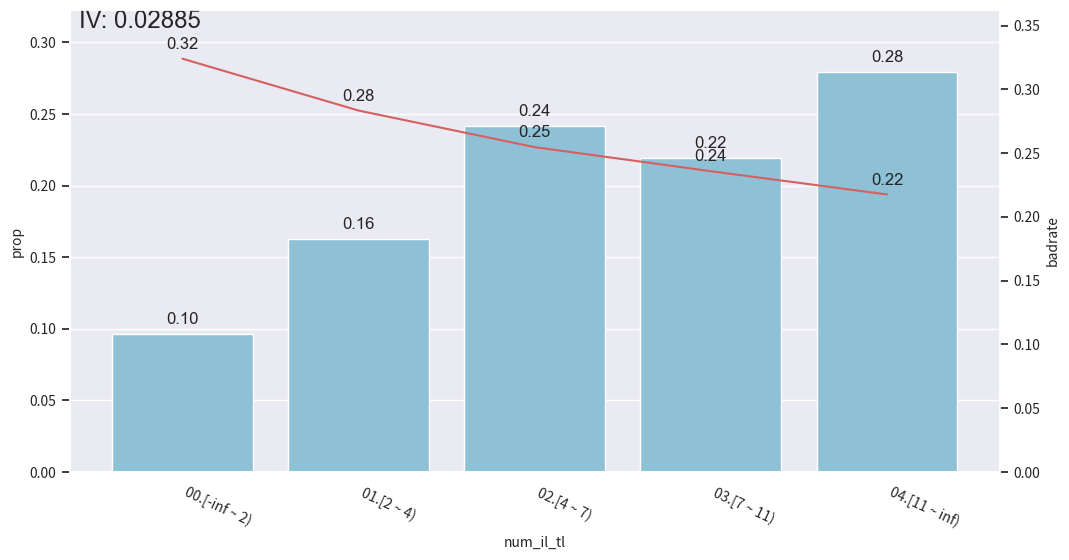

In [158]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['num_il_tl','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['num_il_tl','loan_status']],
           labels=True), x='num_il_tl', target='loan_status')
print(c1.export())

In [159]:
continuous_var_bin.get('mo_sin_old_il_acct')

bin_low  bin_up   total  bin
bin                              
1       -inf   28.81   13021  1.0
2      28.81   66.82   33474  2.0
3      66.82   92.16   25970  3.0
4      92.16  131.98   62398  4.0
5     131.98     inf  116195  5.0
6        NaN     NaN    9091  6.0

{'mo_sin_old_il_acct': [19.0, 68.0, 101.0, 146.0]}


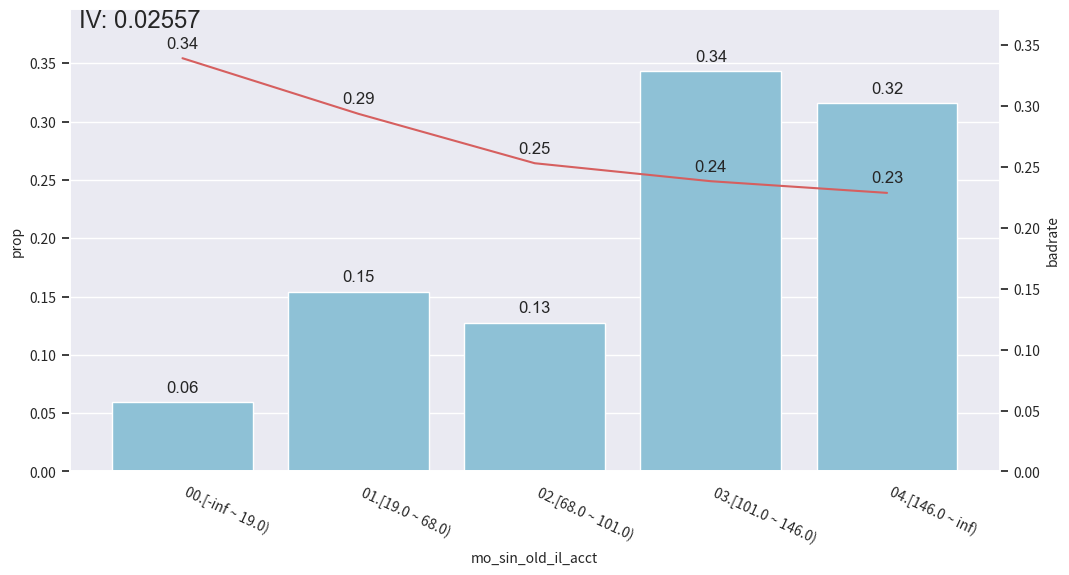

In [160]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['mo_sin_old_il_acct','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['mo_sin_old_il_acct','loan_status']],
           labels=True), x='mo_sin_old_il_acct', target='loan_status')
print(c1.export())

<Axes: xlabel='mo_sin_old_il_acct', ylabel='prop'>

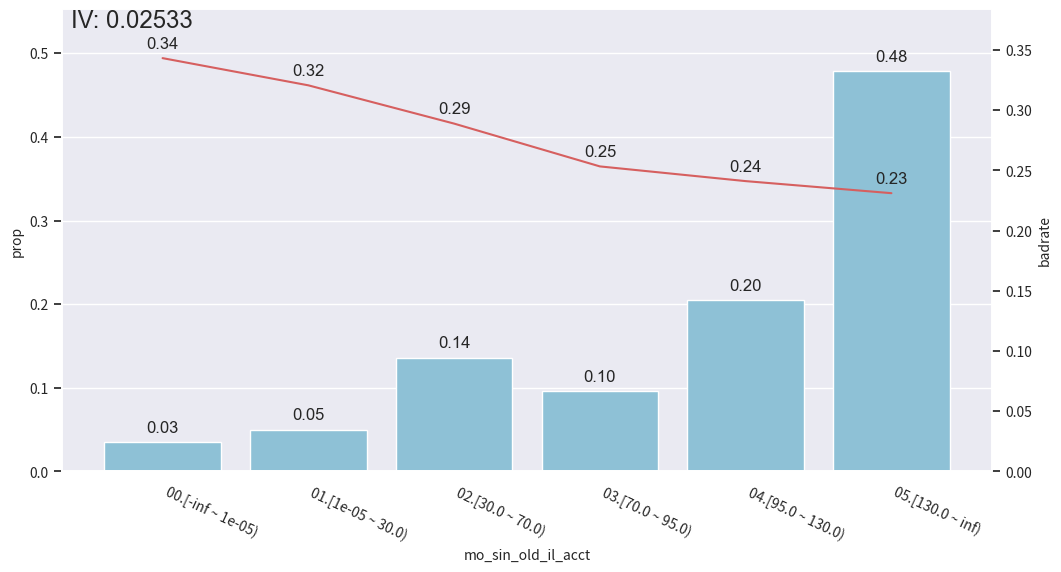

In [161]:
#设置分组
rule = {'mo_sin_old_il_acct':[0.00001,30,70,95,130]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['mo_sin_old_il_acct','loan_status']], labels=True), x='mo_sin_old_il_acct', target='loan_status')

In [162]:
continuous_var_bin.get('annual_inc')

bin_low    bin_up  total  bin
bin                                
1        -inf   30728.0  22557    1
2     30728.0   50790.0  59757    2
3     50790.0   86615.0  98745    3
4     86615.0  100945.0  25128    4
5    100945.0       inf  53962    5

{'annual_inc': [31000.0, 45660.0, 86730.0, 150704.0]}


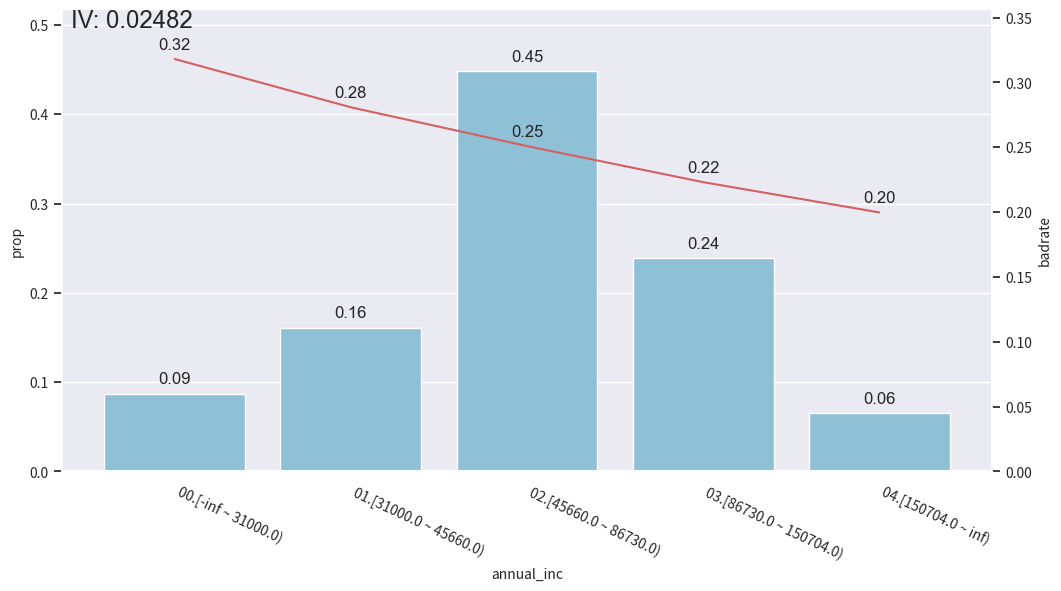

In [163]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['annual_inc','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['annual_inc','loan_status']],
           labels=True), x='annual_inc', target='loan_status')
print(c1.export())

<Axes: xlabel='annual_inc', ylabel='prop'>

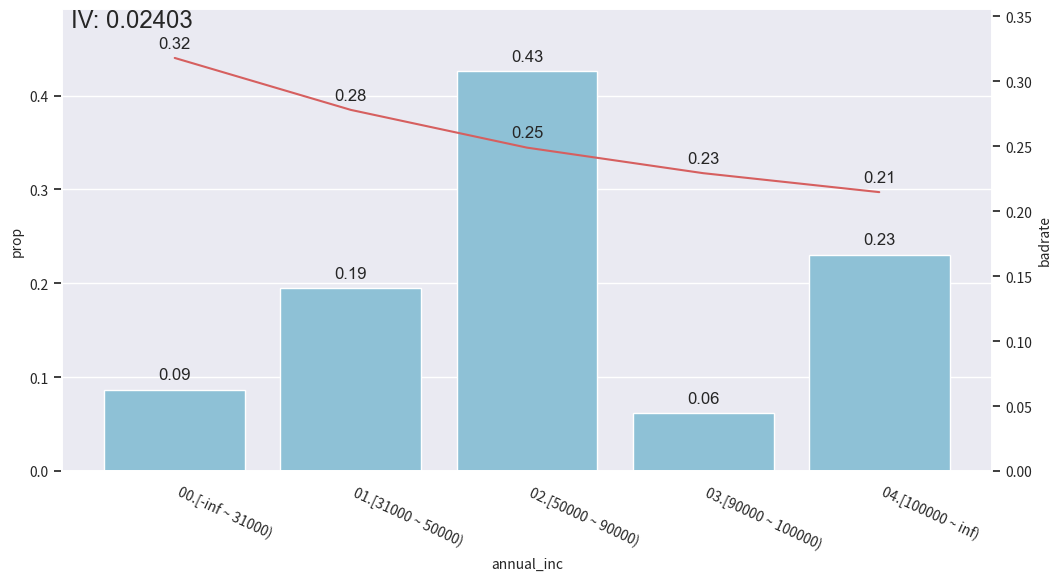

In [164]:
#设置分组
rule = {'annual_inc': [31000,50000,90000,100000]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['annual_inc','loan_status']], labels=True), x='annual_inc', target='loan_status')

In [165]:
continuous_var_bin.get('dti')

bin_low   bin_up   total  bin
bin                               
1       -inf   5.4815   21400  1.0
2     5.4815  17.6286  111419  2.0
3    17.6286  23.8663   56197  3.0
4    23.8663  31.4172   42937  4.0
5    31.4172      inf   27555  5.0
6        NaN      NaN     641  6.0

{'dti': [8.030000000000001, 15.62, 19.45, 25.62, 32.480000000000004]}


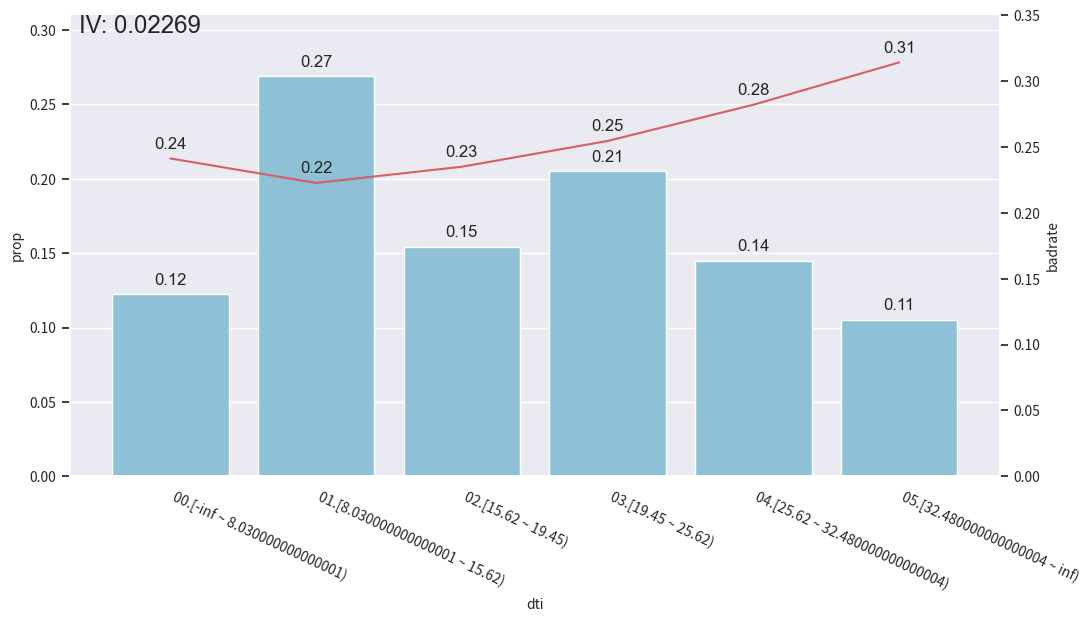

In [166]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['dti','loan_status']],
        y='loan_status', method='chi',n_bins=6)  
bin_plot(c1.transform(data_X2[['dti','loan_status']],
           labels=True), x='dti', target='loan_status')
print(c1.export())

<Axes: xlabel='dti', ylabel='prop'>

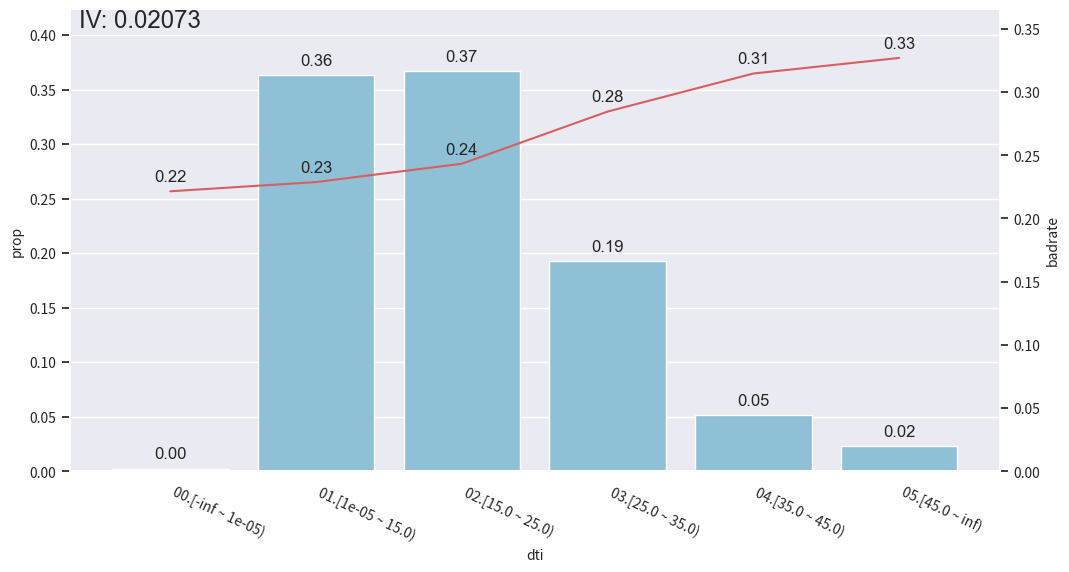

In [167]:
#设置分组
rule = {'dti':[0.00001,15,25,35,45]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['dti','loan_status']], labels=True), x='dti', target='loan_status')

In [168]:
categorical_var_bin.get('inq_last_6mths')

loan_status   total  bin var_name
0              6191    1      3.0
1               113    1      5.0
2               355    1      4.0
3            167051    2      0.0
4             65748    3      1.0
5             20691    4      2.0

{'inq_last_6mths': [1, 2, 3, 4]}


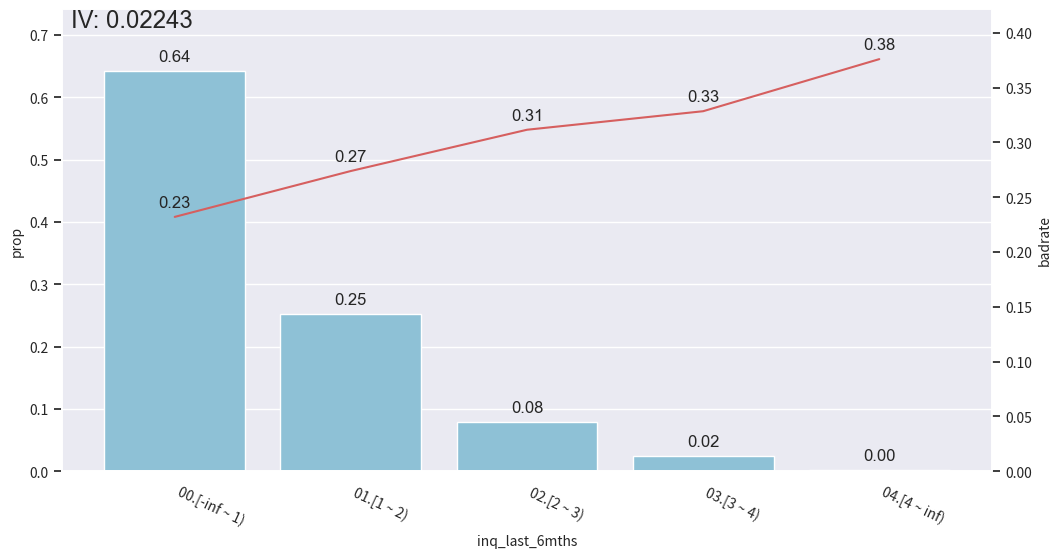

In [169]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['inq_last_6mths','loan_status']],
        y='loan_status', method='chi',n_bins=5)  
bin_plot(c1.transform(data_X2[['inq_last_6mths','loan_status']],
           labels=True), x='inq_last_6mths', target='loan_status')
print(c1.export())

<Axes: xlabel='inq_last_6mths', ylabel='prop'>

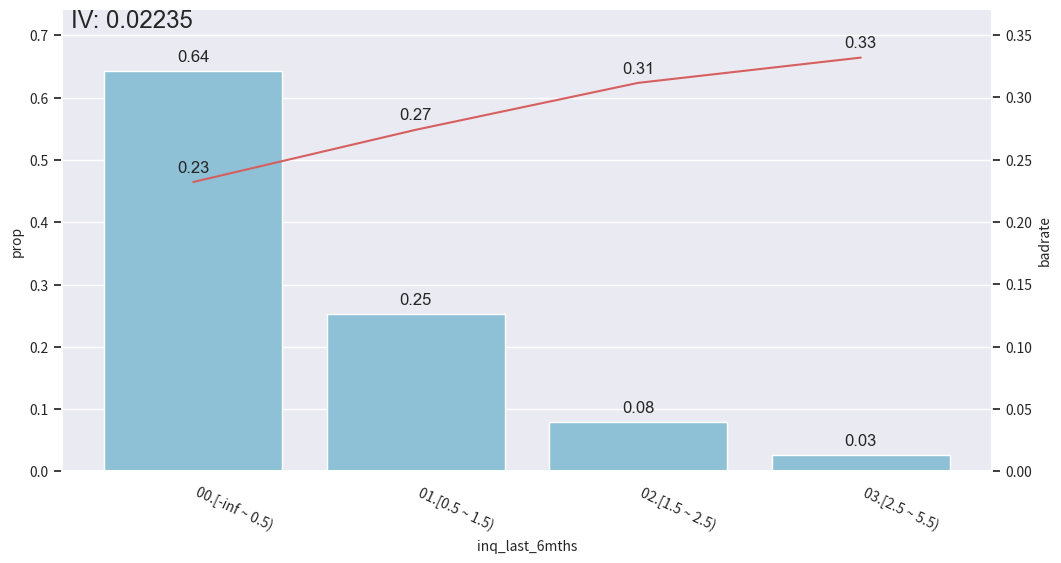

In [170]:
#设置分组
rule = {'inq_last_6mths':[0.5,1.5,2.5,5.5]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['inq_last_6mths','loan_status']], labels=True), x='inq_last_6mths', target='loan_status')

In [171]:
continuous_var_bin.get('mths_since_recent_inq')

bin_low  bin_up   total  bin
bin                              
1       -inf    0.25   18710  1.0
2       0.25    1.00   24030  2.0
3       1.00    3.00   39463  3.0
4       3.00    6.00   47048  4.0
5       6.00     inf  104535  5.0
6        NaN     NaN   26363  6.0

{'mths_since_recent_inq': [2.0, 4.0, 6.0, 8.0, 12.0]}


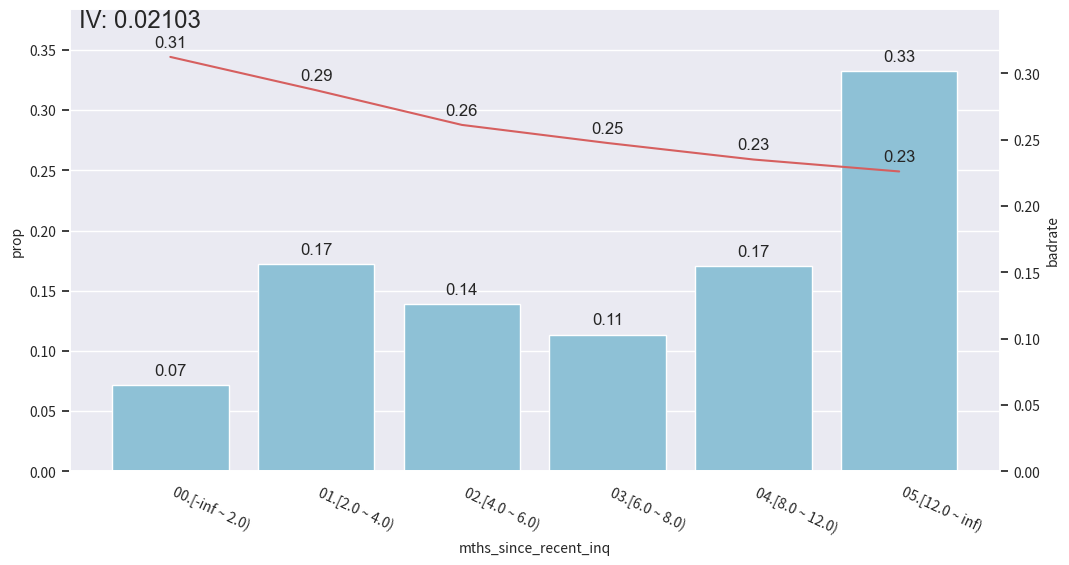

In [172]:
c1 = toad.transform.Combiner()  
c1.fit(data_X2[['mths_since_recent_inq','loan_status']],
        y='loan_status', method='chi',n_bins=6)  
bin_plot(c1.transform(data_X2[['mths_since_recent_inq','loan_status']],
           labels=True), x='mths_since_recent_inq', target='loan_status')
print(c1.export())

<Axes: xlabel='mths_since_recent_inq', ylabel='prop'>

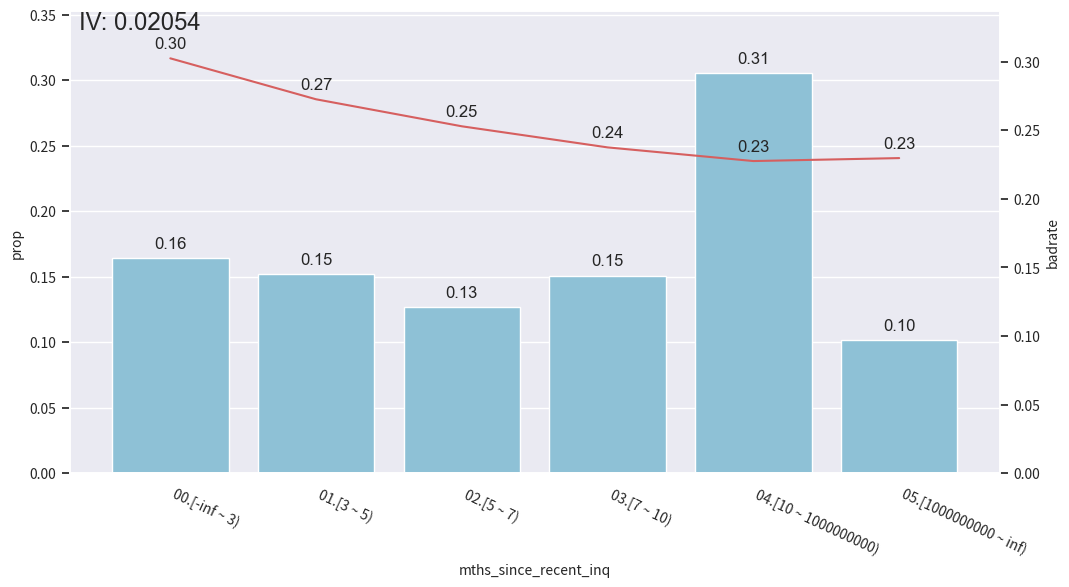

In [173]:
#设置分组
rule = {'mths_since_recent_inq':[3,5,7,10,1000000000]}
#调整分箱
c1.set_rules(rule)
#查看手动分箱稳定性
bin_plot(c1.transform(data_X2[['mths_since_recent_inq','loan_status']], labels=True), x='mths_since_recent_inq', target='loan_status')

In [174]:
data_X_2 =data_X2.drop(columns = ['loan_status'])
data_y_2 = data_X2['loan_status']

In [175]:
分箱={'term':{0:[' 36 months'],1:[' 60 months']},'fico_range_high':[-np.inf,690,710,750,800,np.inf],
   'installment':[-np.inf,160,330,500,700,np.inf],'tot_hi_cred_lim':[-np.inf,39000,120000,240000,500000,np.inf],
   'mort_acc':[-np.inf,1,2,3,np.inf],'bc_open_to_buy':[-np.inf,6000,11999.99999,12000.00001,20000,40000,np.inf],
   'home_ownership':{0:['MORTGAGE'],1:['OWN'],2:['RENT','ANY']},'verification_status':{0:['Not Verified'],1:['Source Verified'],2:['Verified']},
   'open_rv_24m':[-np.inf,2,3,4,7,np.inf],'bc_util':[-np.inf,20,39.99999,40.00001,55,70,np.inf],
   'num_actv_rev_tl':[-np.inf,4,5,7,9,np.inf],'mo_sin_old_rev_tl_op':[-np.inf,50,85,130,150,np.inf],
   'emp_length':{0:['nan'],1:['< 1 year','1 year'],2:['2 years','3 years','4 years','5 years'],3:['6 years','7 years','8 years'],4:['9 years','10+ years']},
   'num_il_tl':[-np.inf,2,4,7,11,np.inf],'mo_sin_old_il_acct':[-np.inf,0.00001,30,70,95,130,np.inf],
   'annual_inc':[-np.inf,31000,50000,90000,100000,np.inf],'dti':[-np.inf,0.00001,15,25,35,45,np.inf],
   'inq_last_6mths':[-np.inf,0.5,1.5,2.5,np.inf],'mths_since_recent_inq':[-np.inf,3,5,7,10,999999999.99999,np.inf]}

In [176]:
空值分箱 = {'emp_length':0}

In [177]:
dis_cols = ['term','home_ownership','verification_status','emp_length']#,,'bc_open_to_buy''bc_open_to_buy','bc_util','mo_sin_old_il_acct','dti','mths_since_recent_inq'#]
sample1_bins = copy.deepcopy(data_X_2)
for k,v in 分箱.items():
    x = sample1_bins[k]
    bins = 分箱.get(k)
    if k in dis_cols:
        old_values,new_values = [],[]
        for k_,v_ in bins.items():
            old_values.extend(v_)
            new_values.extend([k_] * len(v_))
            sample1_bins[k] = x.replace(old_values + [np.nan],new_values + [空值分箱.get(k)])
    else:
        labels = list(np.arange(0,len(bins) - 1,dtype = int))
        x = pd.cut(x,bins = bins,labels = labels)
        sample1_bins[k] = x.replace([np.nan],[空值分箱.get(k)])

In [178]:
data_X_2

term  fico_range_high  installment  tot_hi_cred_lim  mort_acc  \
0        60 months              669       560.94           172433         3   
1        36 months              739       602.21           168738         4   
2        36 months              699       161.15            98637         0   
3        36 months              719       320.01           217992         1   
4        36 months              764       467.47           512289         2   
...            ...              ...          ...              ...       ...   
260144   60 months              689       571.22           238344         2   
260145   36 months              709       176.14            17294         0   
260146   36 months              694       660.00            42400         3   
260147   36 months              669       176.14           161585         1   
260148   36 months              694       797.53           296500         6   

        bc_open_to_buy home_ownership verification_status  open_rv_24m  \
0              16685.0            OWN     Source Verified            5   
1              15289.0            OWN            Verified            0   
2               2158.0           RENT        Not Verified            0   
3              14182.0       MORTGAGE     Source Verified            3   
4              12000.0       MORTGAGE     Source Verified            3   
...                ...            ...                 ...          ...   
260144          3541.0       MORTGAGE        Not Verified            3   
260145          1823.0            OWN     Source Verified            6   
260146          1594.0            OWN        Not Verified            1   
260147           115.0       MORTGAGE     Source Verified            5   
260148         26322.0       MORTGAGE     Source Verified            6   

        bc_util  num_actv_rev_tl  mo_sin_old_rev_tl_op emp_length  num_il_tl  \
0          39.4                7                   112  10+ years          3   
1          70.7                4                   206    5 years         20   
2          76.2                6                   262  10+ years         10   
3          23.1                3                   304  10+ years         14   
4          40.0                6                   174    6 years         23   
...         ...              ...                   ...        ...        ...   
260144     52.0               16                   233  10+ years          4   
260145     44.1                4                    33        NaN          2   
260146     79.8                6                   177  10+ years          4   
260147     97.2                5                   178    3 years          3   
260148     45.1                5                   397  10+ years          3   

        mo_sin_old_il_acct  annual_inc    dti  inq_last_6mths  \
0                     68.0     85000.0  16.76               0   
1                    212.0     77000.0  23.21               0   
2                    163.0    120000.0  25.88               0   
3                    120.0     65000.0  28.20               0   
4                    141.0    148000.0  24.62               0   
...                    ...         ...    ...             ...   
260144               192.0     60000.0  10.72               1   
260145                42.0      9200.0  24.50               1   
260146                72.0     45000.0  23.13               0   
260147               121.0     46400.0  17.85               0   
260148                13.0     75000.0  21.95               2   

        mths_since_recent_inq  
0                1.000000e+00  
1                1.000000e+09  
2                1.000000e+09  
3                4.000000e+00  
4                1.900000e+01  
...                       ...  
260144           4.000000e+00  
260145           7.000000e+00  
260146           1.000000e+09  
260147           1.100000e+01  
260148           5.000000e+00  

[260149 rows x 19 columns]

In [179]:
sample1_bins

term fico_range_high installment tot_hi_cred_lim mort_acc  \
0          1               0           3               2        2   
1          0               2           3               2        3   
2          0               1           1               1        0   
3          0               2           1               2        0   
4          0               3           2               4        1   
...      ...             ...         ...             ...      ...   
260144     1               0           3               2        1   
260145     0               1           1               0        0   
260146     0               1           3               1        2   
260147     0               0           1               2        0   
260148     0               1           4               3        3   

       bc_open_to_buy  home_ownership  verification_status open_rv_24m  \
0                   3               1                    1           3   
1                   3               1                    2           0   
2                   0               2                    0           0   
3                   3               0                    1           1   
4                   2               0                    1           1   
...               ...             ...                  ...         ...   
260144              0               0                    0           1   
260145              0               1                    1           3   
260146              0               1                    0           0   
260147              0               0                    1           3   
260148              4               0                    1           3   

       bc_util num_actv_rev_tl mo_sin_old_rev_tl_op  emp_length num_il_tl  \
0            1               2                    2         4.0         1   
1            5               0                    4         2.0         4   
2            5               2                    4         4.0         3   
3            1               0                    4         4.0         4   
4            2               2                    4         3.0         4   
...        ...             ...                  ...         ...       ...   
260144       3               4                    4         4.0         1   
260145       3               0                    0         0.0         0   
260146       5               2                    4         4.0         1   
260147       5               1                    4         2.0         1   
260148       3               1                    4         4.0         1   

       mo_sin_old_il_acct annual_inc dti inq_last_6mths mths_since_recent_inq  
0                       2          2   2              0                     0  
1                       5          2   2              0                     5  
2                       5          4   3              0                     5  
3                       4          2   3              0                     1  
4                       5          4   2              0                     4  
...                   ...        ...  ..            ...                   ...  
260144                  5          2   1              1                     1  
260145                  2          0   2              1                     2  
260146                  3          1   2              0                     5  
260147                  4          1   2              0                     4  
260148                  1          2   2              2                     1  

[260149 rows x 19 columns]

In [180]:
pd.concat([sample1_bins,data_y_2],axis = 1).to_excel('最终2018年改变分箱最后19个特征数据的分箱.xlsx',index = False)

# woe编码

In [181]:
data_X_woe = pd.DataFrame()
for col_x in tqdm.tqdm([x + '_BIN' for x in data_X_bin.columns]):
    guize = woe_list.get(col_x)
    data_X_woe[col_x[:-4]] = data_X_bin[col_x[:-4]].replace(list(guize.index),list(guize.values))

100%|██████████| 67/67 [00:01<00:00, 66.52it/s]


In [182]:
data_X_woe_IV = data_X_woe[data_X_bin_IV.columns]

In [183]:
## 保存WOE规则
woe_save = open('woe_list.pkl','wb')
pickle.dump(woe_list,woe_save)
woe_save.close()

In [184]:
## 合并特征和标签
pd.concat([data_X_woe_IV,data_y],axis = 1).to_excel('最终2018年改变分箱最后19个特征数据的入模训练集.xlsx',index = False)

MemoryError: 